# Stock Exchange Price Forecasting


## Import Libraries


In [158]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from warnings import filterwarnings

# Avoid showing warnings to keep the notebook outputs clean.
filterwarnings("ignore")


## Data Cleaning

### Load the Data

In [159]:
# Load the stock data and check whether it has been loaded correctly.
data = pd.read_csv(
    "data/index_data.csv",
    on_bad_lines="error",
)


### Convert Date Column to Datetime

In [160]:
data["Date"] = pd.to_datetime(data["Date"])
print("Data Info Overview:")
data.info()

Data Info Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112457 entries, 0 to 112456
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Index      112457 non-null  object        
 1   Date       112457 non-null  datetime64[ns]
 2   Open       110253 non-null  float64       
 3   High       110253 non-null  float64       
 4   Low        110253 non-null  float64       
 5   Close      110253 non-null  float64       
 6   Adj Close  110253 non-null  float64       
 7   Volume     110253 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.9+ MB


### Remove Incomplete Rows

In [161]:
# Count how many missing values are in each column.
print("Number of Missing Values Per Column:")
display(data.isnull().sum())

# Remove rows with missing values.
data.dropna(axis=0, how="any", inplace=True)

# Check that the missing values have been removed.
print("Number of Missing Values Per Column After Cleaning:")
display(data.isnull().sum())

Number of Missing Values Per Column:


Index           0
Date            0
Open         2204
High         2204
Low          2204
Close        2204
Adj Close    2204
Volume       2204
dtype: int64

Number of Missing Values Per Column After Cleaning:


Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Remove Rows with Missing Volume

In [162]:
# Exclude days with missing volume, as this will skew the distribution of the
# data.
print(f"Number of Rows Before Excluding Days with Missing Volume: {len(data)}")
data = data.loc[data["Volume"] != 0]
print(
    "Number of Rows After Excluding Days with Missing "
    f"Volume: {len(data)}"
)


Number of Rows Before Excluding Days with Missing Volume: 110253
Number of Rows After Excluding Days with Missing Volume: 68160


## Data Exploration


### Explore the Index Information


In [163]:
# Load the index info to understand what each index ticker represents.
index_info = pd.read_csv(
    "data/index_info.csv",
    on_bad_lines="error",
)
display(index_info)


Region                          Exchange      Index Currency
0   United States           New York Stock Exchange        NYA      USD
1   United States                            NASDAQ       IXIC      USD
2       Hong Kong          Hong Kong Stock Exchange        HSI      HKD
3           China           Shanghai Stock Exchange  000001.SS      CNY
4           Japan              Tokyo Stock Exchange       N225      JPY
5          Europe                          Euronext       N100      EUR
6           China           Shenzhen Stock Exchange  399001.SZ      CNY
7          Canada            Toronto Stock Exchange     GSPTSE      CAD
8           India  National Stock Exchange of India       NSEI      INR
9         Germany          Frankfurt Stock Exchange      GDAXI      EUR
10          Korea                    Korea Exchange       KS11      KRW
11    Switzerland                SIX Swiss Exchange       SSMI      CHF
12         Taiwan             Taiwan Stock Exchange       TWII      TWD
13   South Africa       Johannesburg Stock Exchange    J203.JO      ZAR

### Split the Data by Index

In [164]:
# Split the data set by 'Index' column.
data_frames_per_index = {
    key: data.loc[value] for key, value in data.groupby("Index").groups.items()
}

# Show how many rows of data are available for each index.
print("Sample Size Per Index:")
for index, data_frame in data_frames_per_index.items():
    print(f"{index}: {len(data_frame)}")


Sample Size Per Index:
000001.SS: 4430
399001.SZ: 4190
GDAXI: 5464
GSPTSE: 9183
HSI: 4890
IXIC: 9233
KS11: 6029
N100: 3817
N225: 4635
NSEI: 2026
NYA: 5115
SSMI: 4632
TWII: 4516


### Calculate Distribution of Features


Distribution of Features in Nasdaq Composite:


Open          High           Low         Close     Adj Close  \
count   9233.000000   9233.000000   9233.000000   9233.000000   9233.000000   
mean    2674.264204   2692.163699   2653.589646   2674.099046   2674.099046   
std     2605.349472   2622.051911   2585.879459   2605.468119   2605.468119   
min      238.000000    238.399994    237.699997    238.100006    238.100006   
25%      730.059998    732.969971    727.609985    730.799988    730.799988   
50%     2012.869995   2029.270020   1993.739990   2009.880005   2009.880005   
75%     3229.810059   3249.780029   3195.570068   3222.370117   3222.370117   
max    14204.509770  14211.570310  14064.280270  14138.780270  14138.780270   

             Volume  
count  9.233000e+03  
mean   1.362774e+09  
std    1.094822e+09  
min    3.884000e+07  
25%    2.722500e+08  
50%    1.584200e+09  
75%    1.983830e+09  
max    1.110216e+10

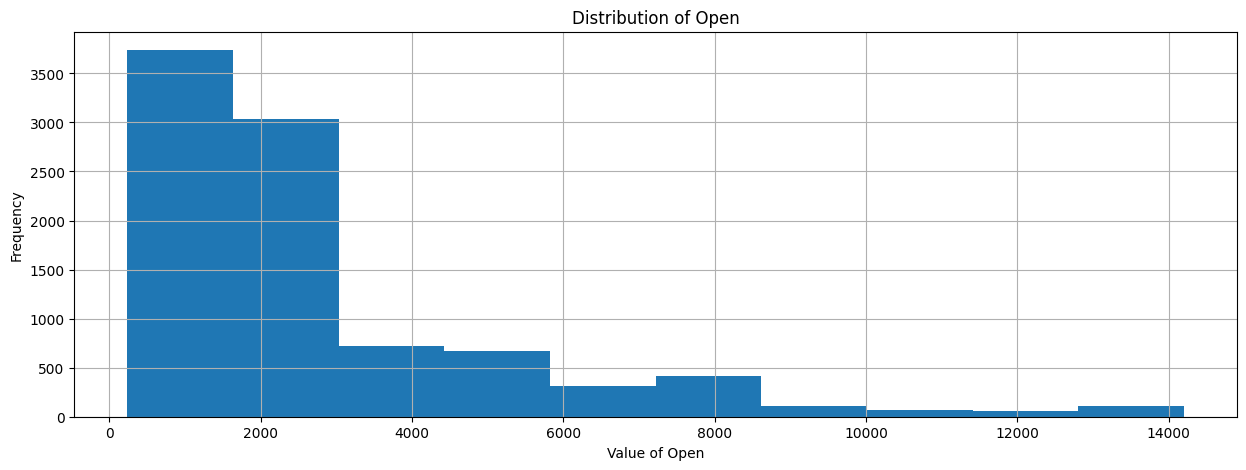

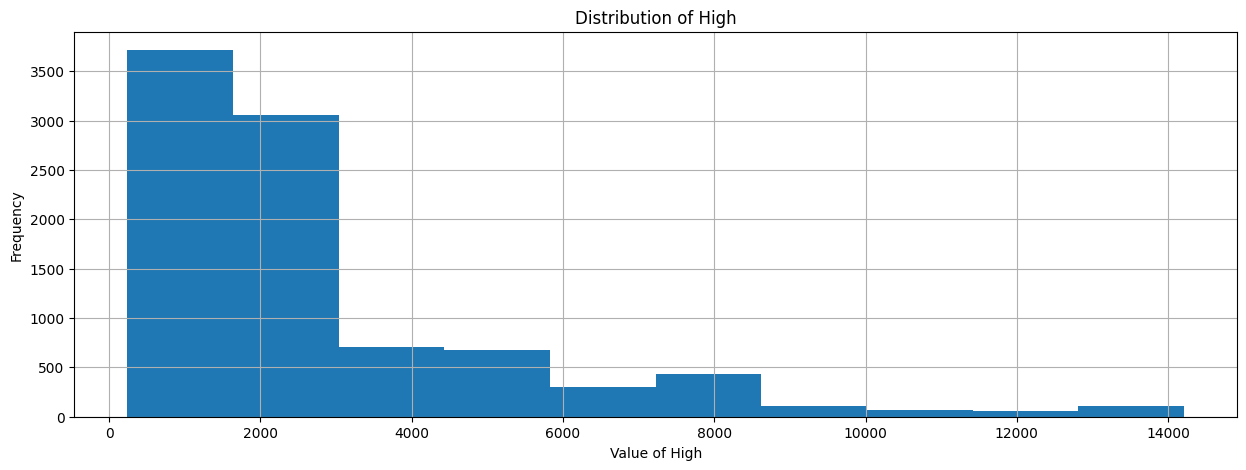

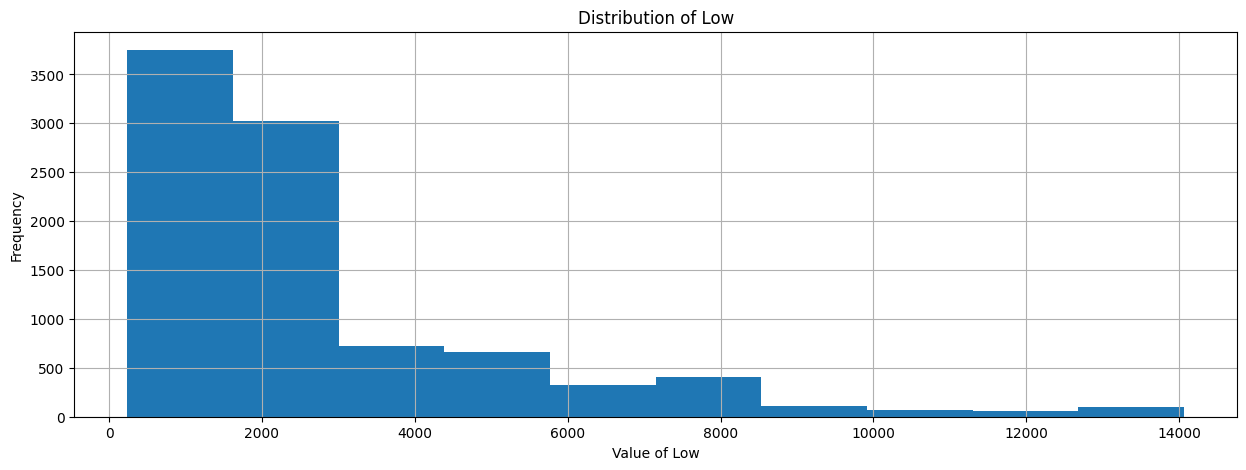

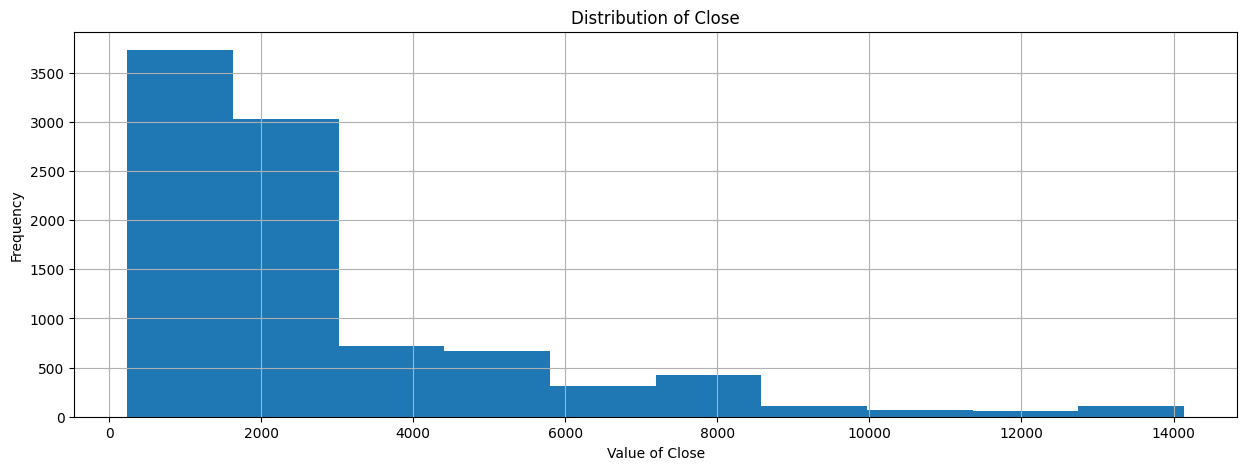

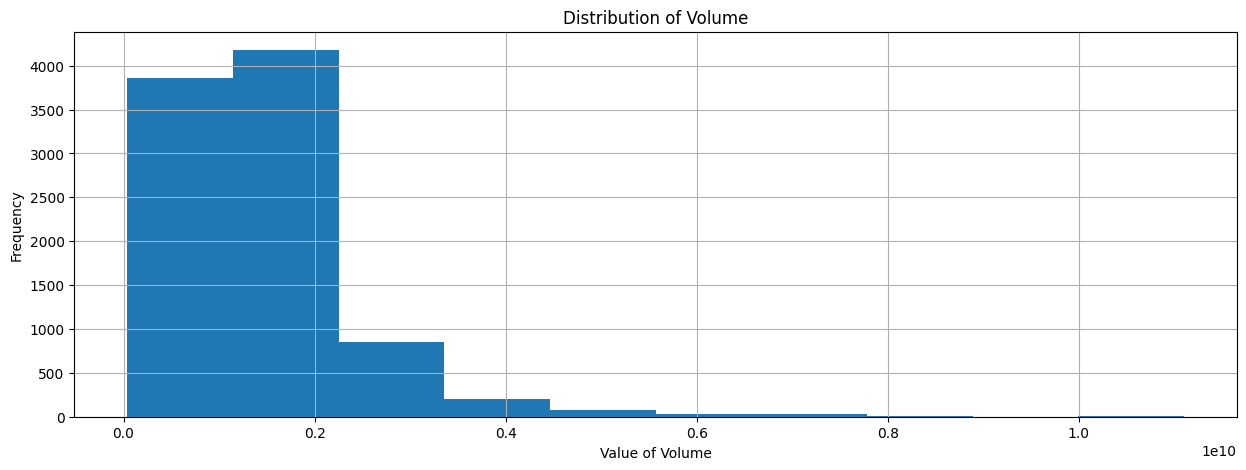

In [165]:
# Focus on the IXIC (Nasdaq Composite) data to simplify our analysis.
ixic_data = data_frames_per_index["IXIC"]

print("\nDistribution of Features in Nasdaq Composite:")
display(ixic_data.describe())
# Create a histogram of each feature to see the distribution of the data.
for column in ixic_data.columns:
    # Skip the index and date columns as they're metadata rather than features.
    if column not in ["Index", "Date", "Adj Close"]:
        plt.figure(figsize=(15, 5))
        ixic_data[column].hist()
        plt.title(f"Distribution of {column}")
        plt.xlabel(f"Value of {column}")
        plt.ylabel("Frequency")
    plt.show()


### Identify Feature Importance


Correlation of Features to Adjusted Close Price in Nasdaq Composite


Close        1.000000
Adj Close    1.000000
Low          0.999934
High         0.999924
Open         0.999872
Volume       0.784782
Name: Adj Close, dtype: float64

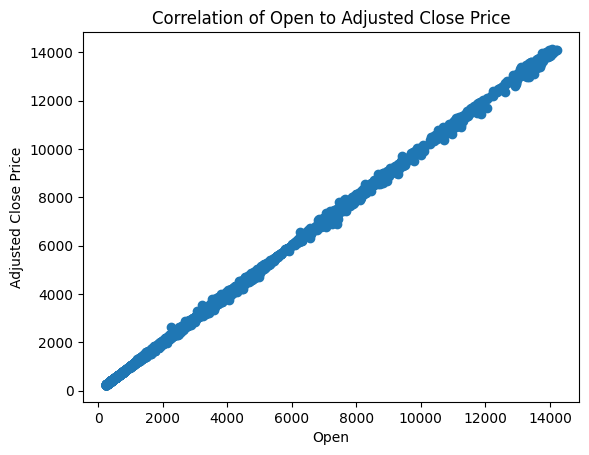

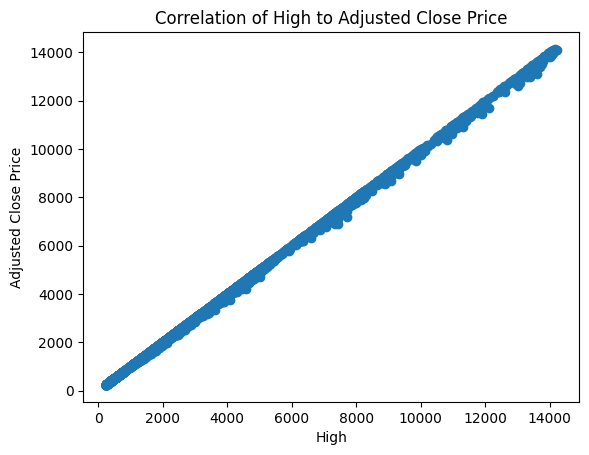

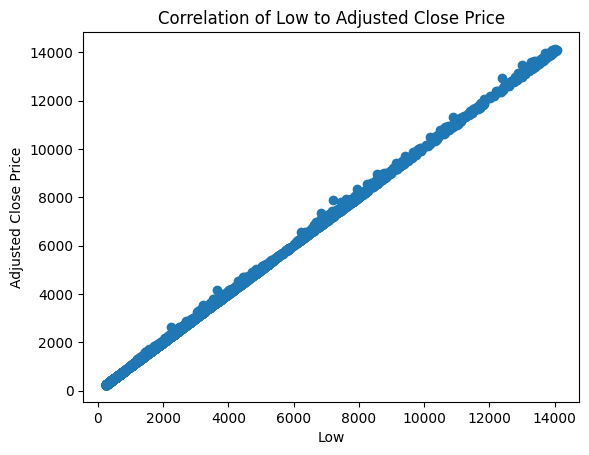

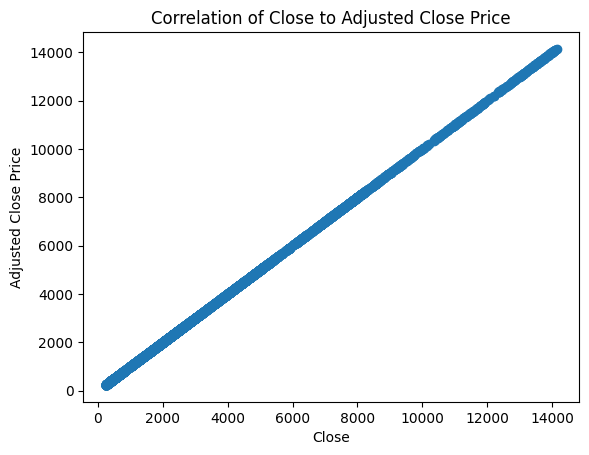

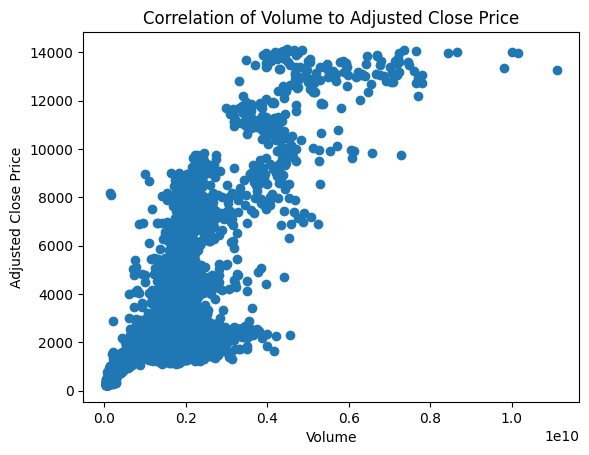

In [166]:
# Show how each feature contributes to the target variable of adjusted close
# price for each index.
print(f"Correlation of Features to Adjusted Close Price in Nasdaq Composite")
display(
    ixic_data.corr(numeric_only=True)["Adj Close"].sort_values(ascending=False)
)

# Visualise the correlation between each feature and the adjusted close price.
for feature in ixic_data.columns:
    # Skip the index and date columns as they're metadata rather than features.
    if feature not in ["Index", "Date", "Adj Close"]:
        plt.scatter(ixic_data[feature], ixic_data["Adj Close"])
        plt.xlabel(feature)
        plt.ylabel("Adjusted Close Price")
        plt.title(f"Correlation of {feature} to Adjusted Close Price")
        plt.show()


## Feature Engineering


### Calculate Simple Moving Averages


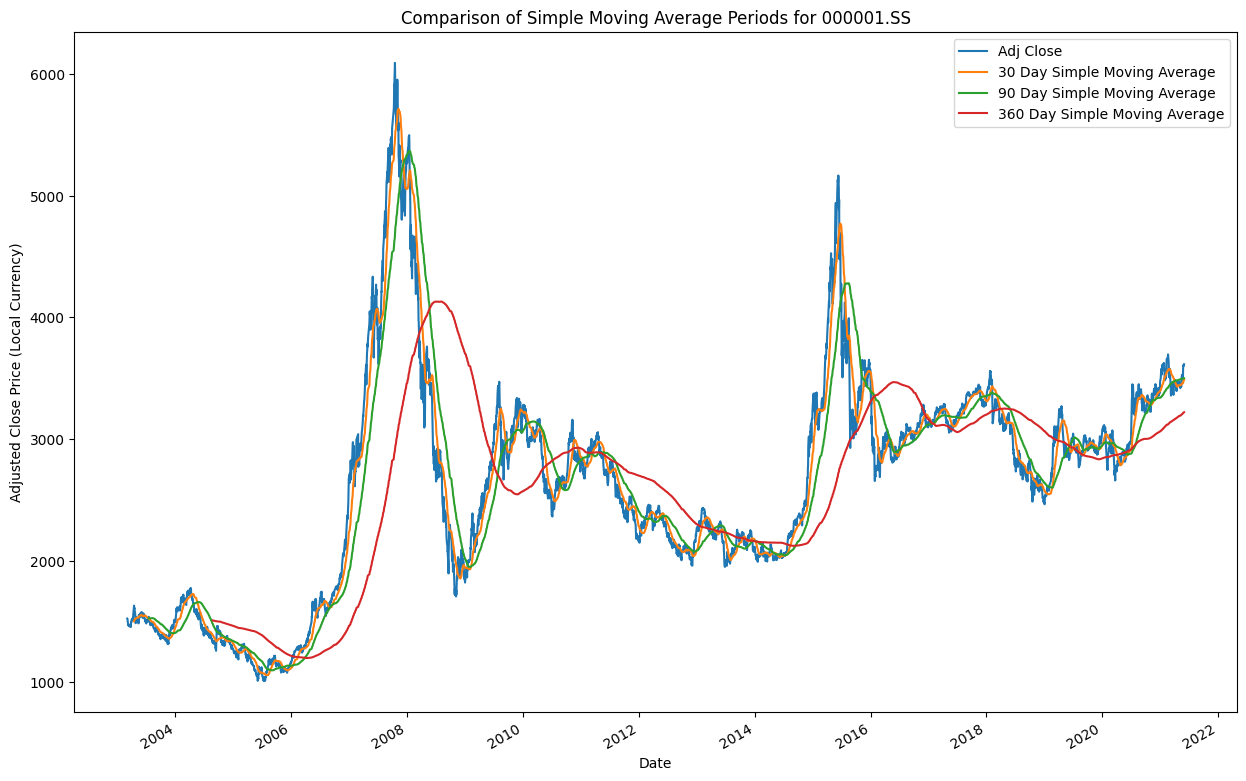

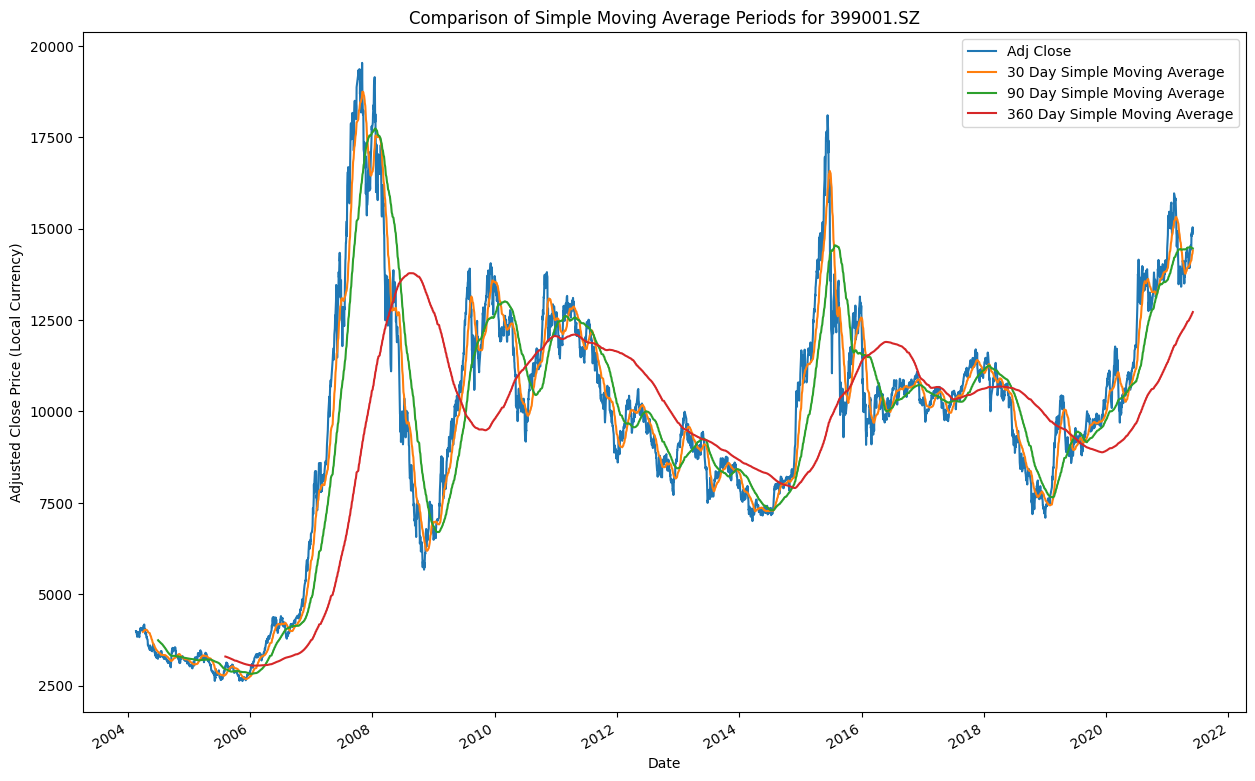

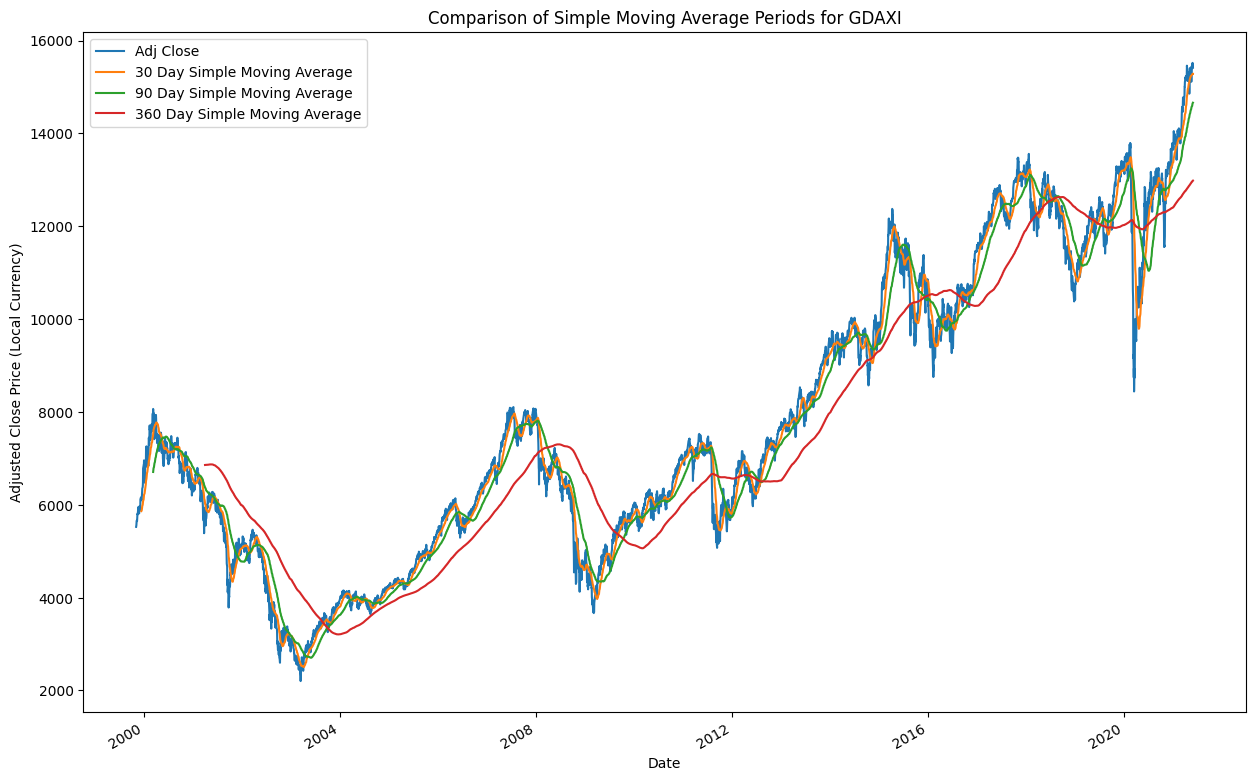

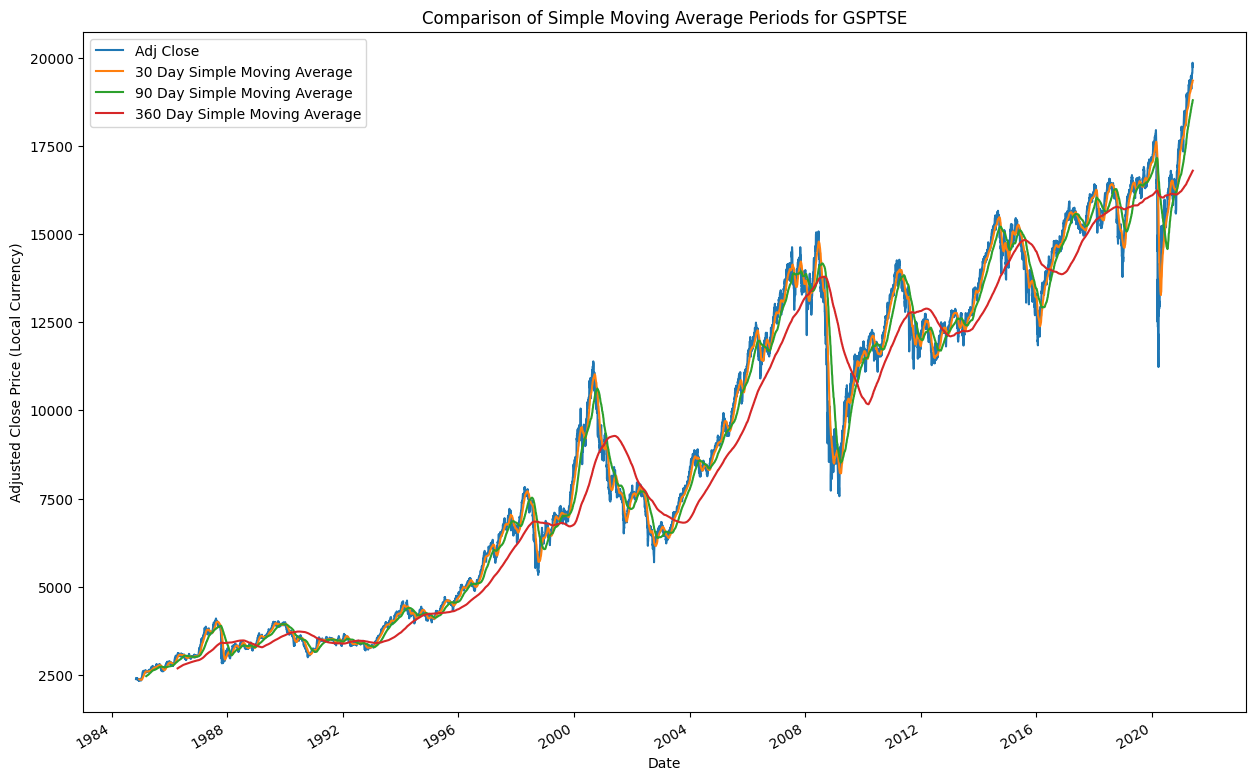

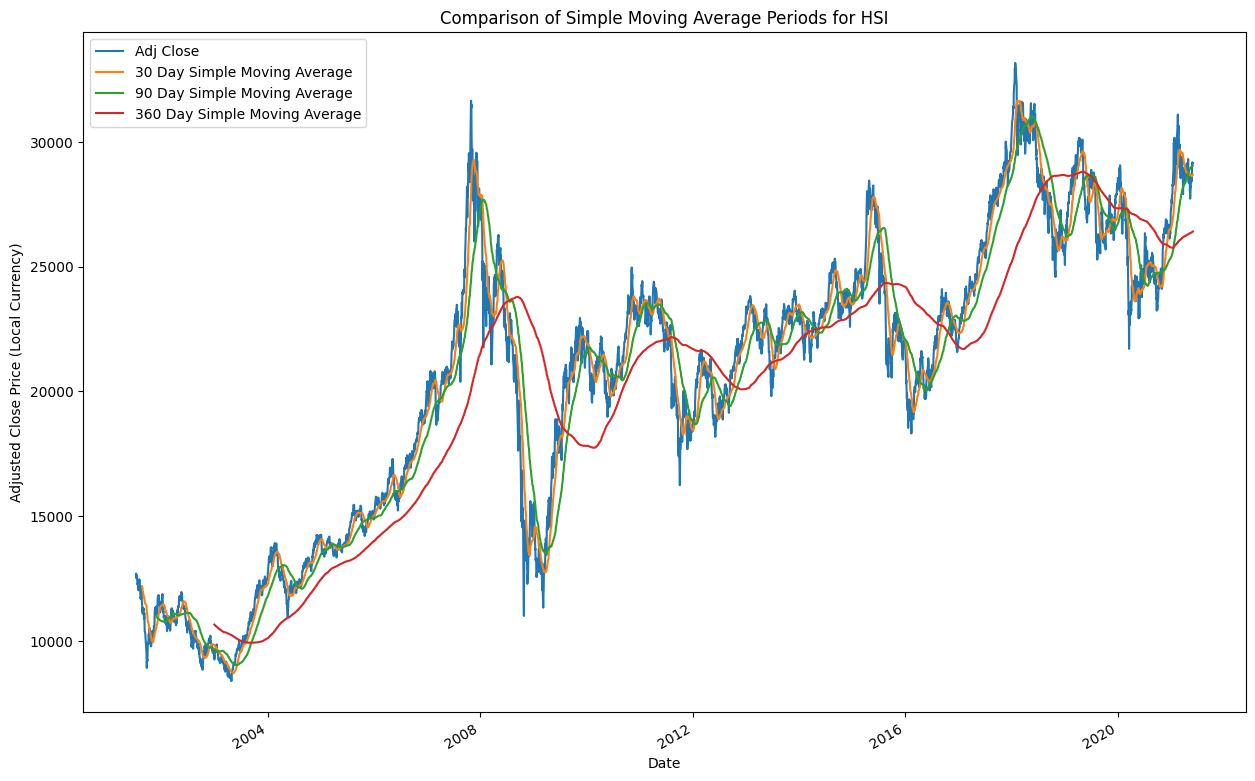

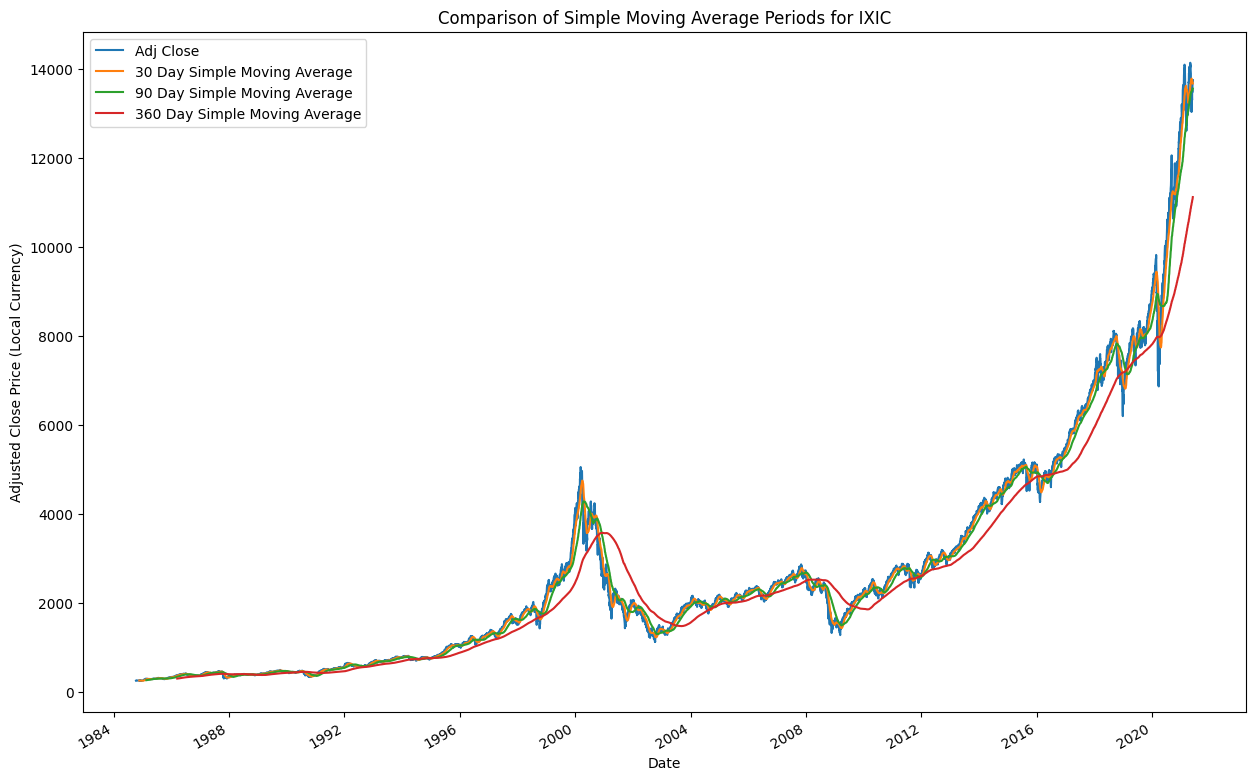

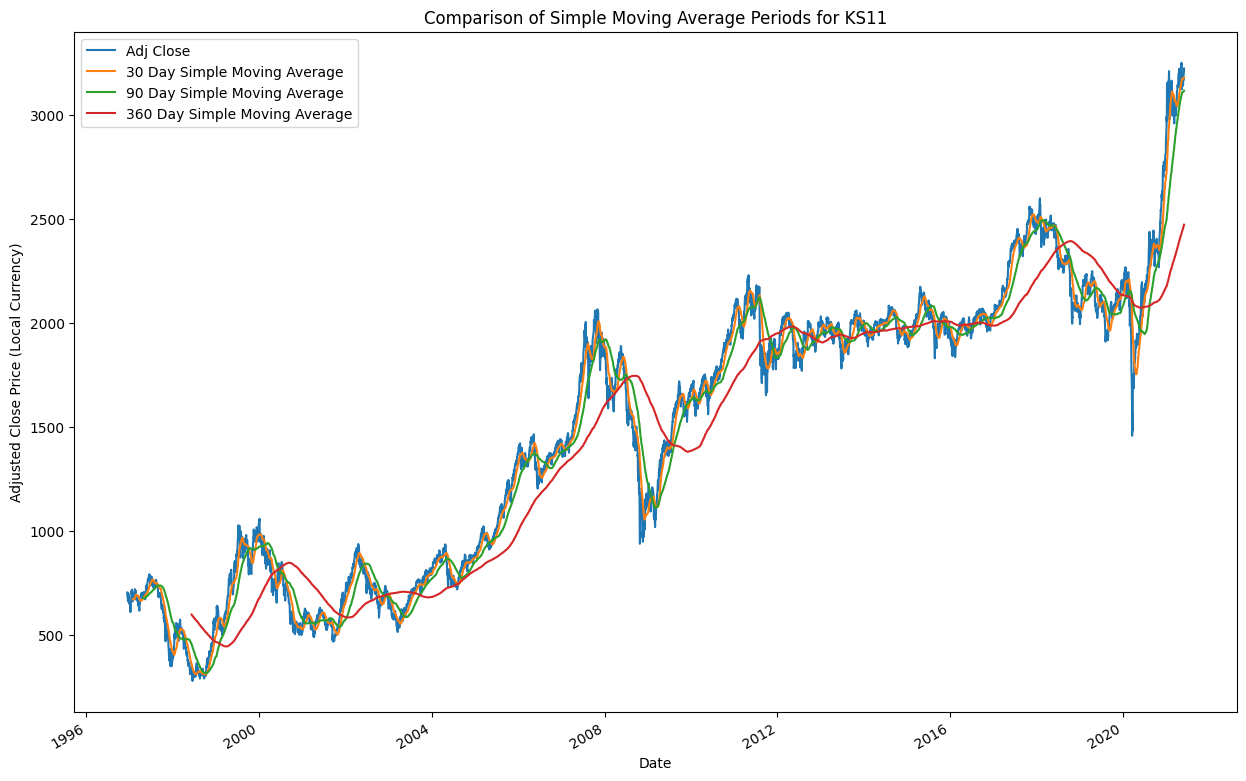

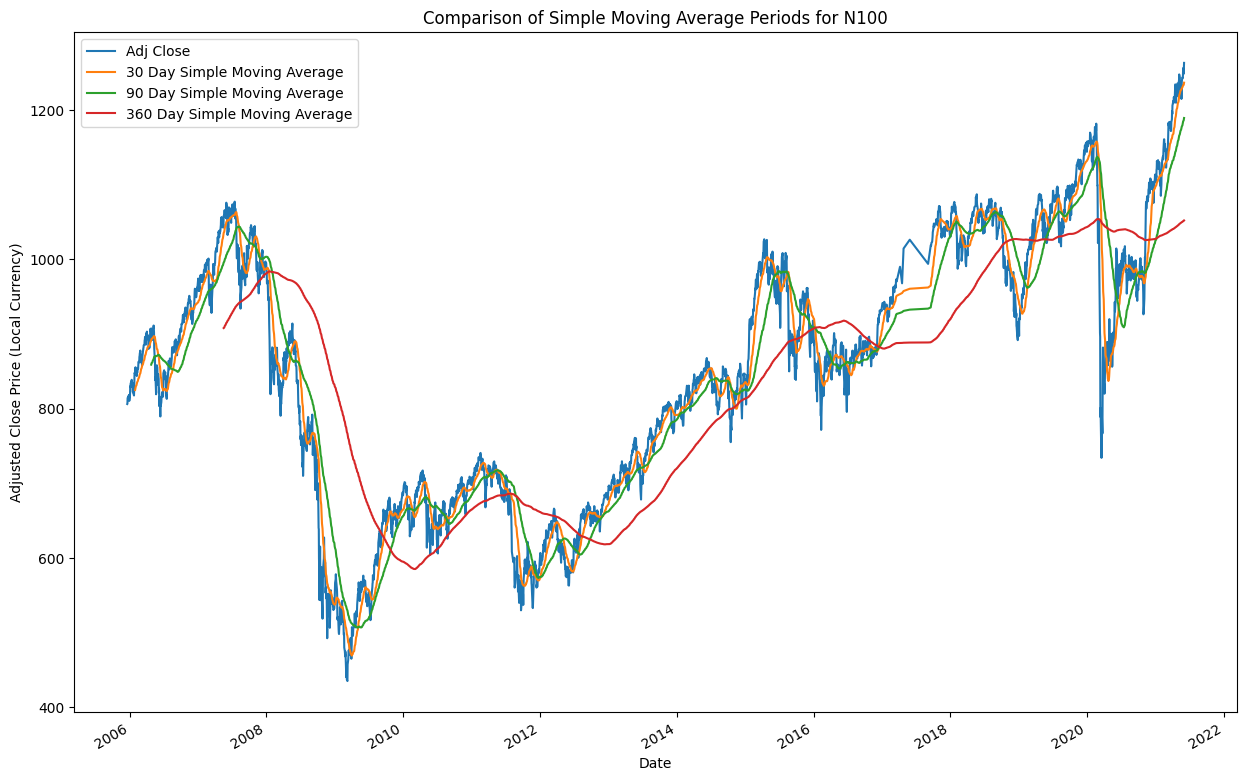

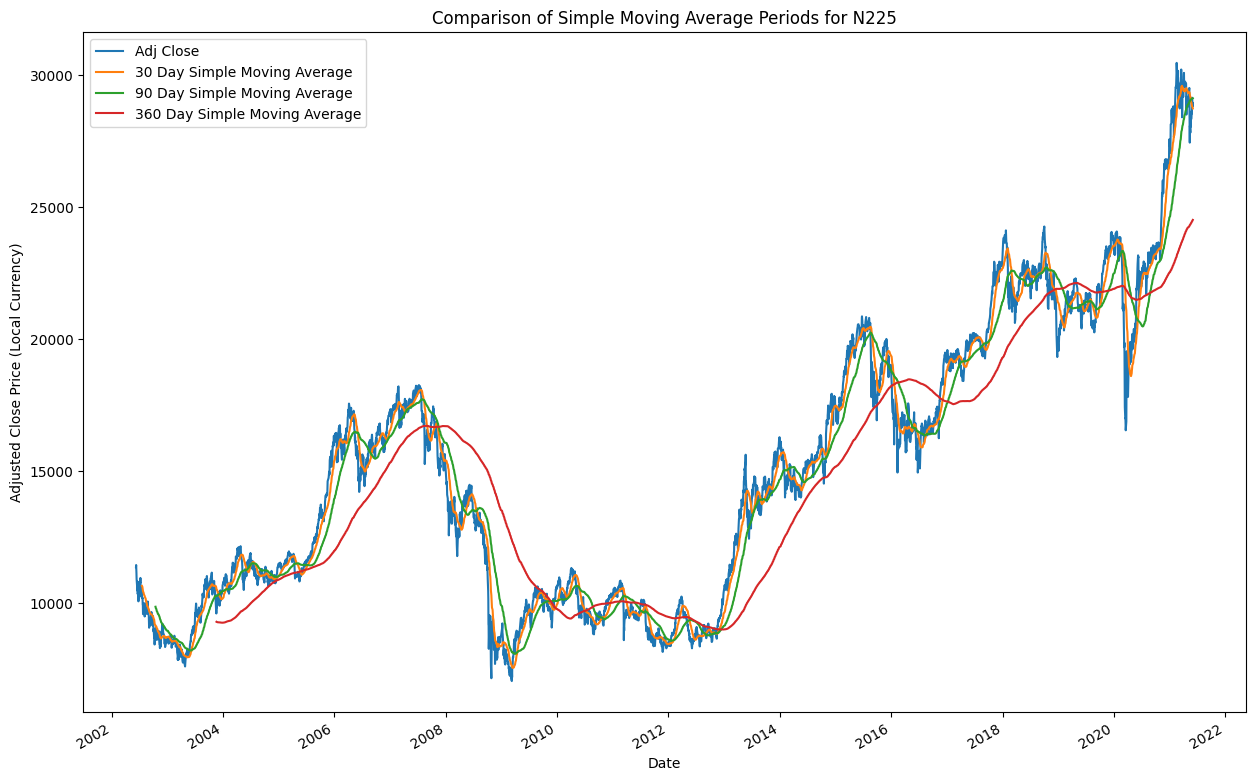

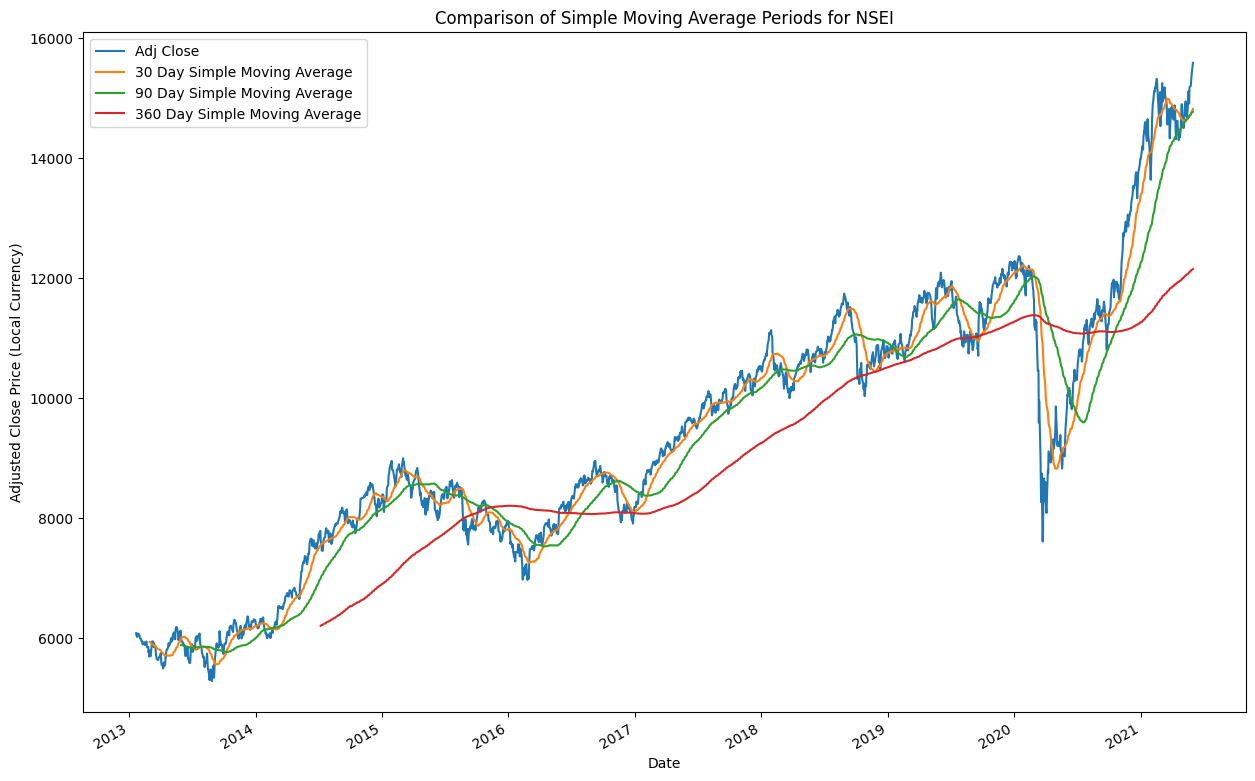

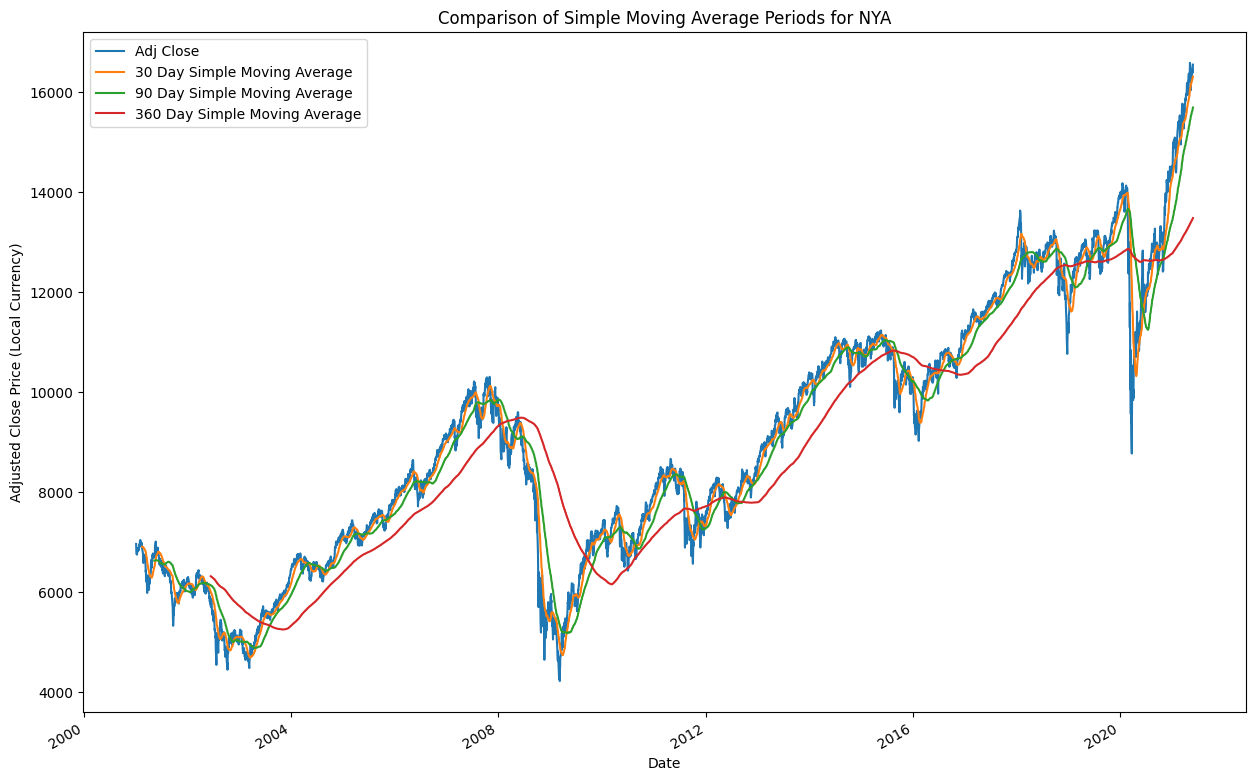

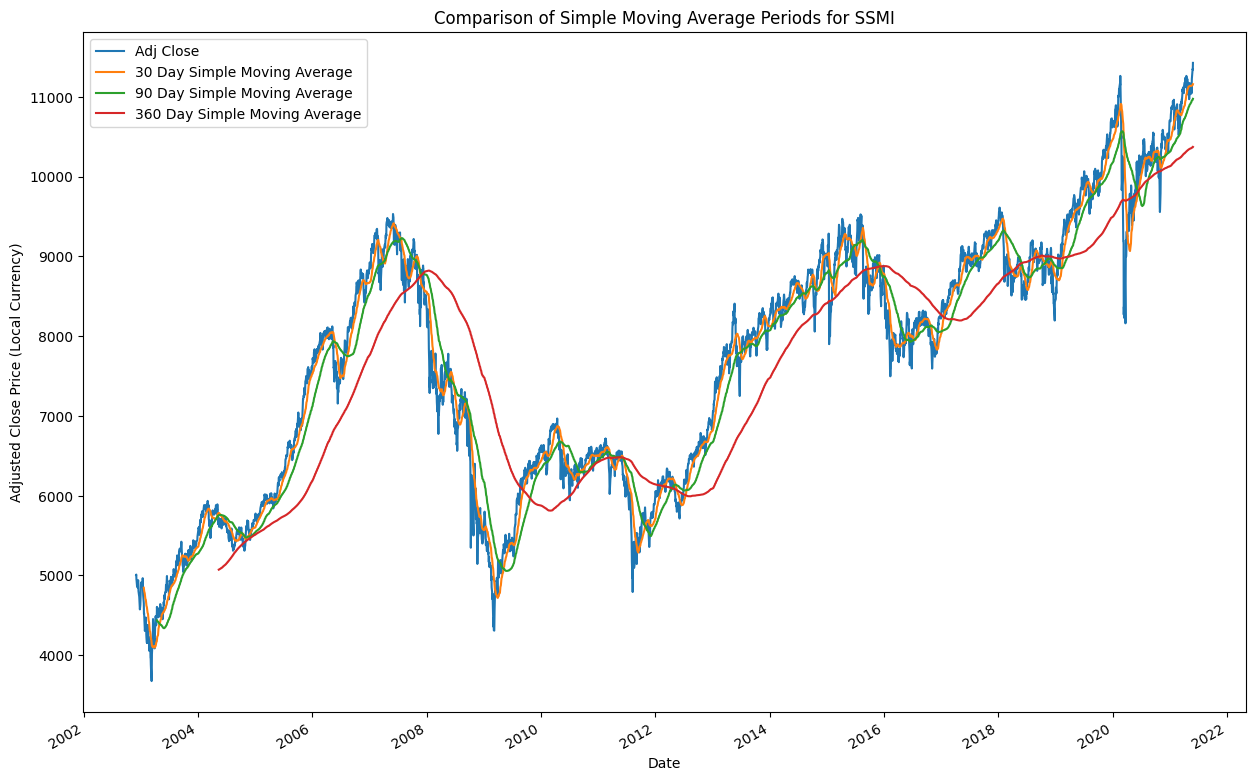

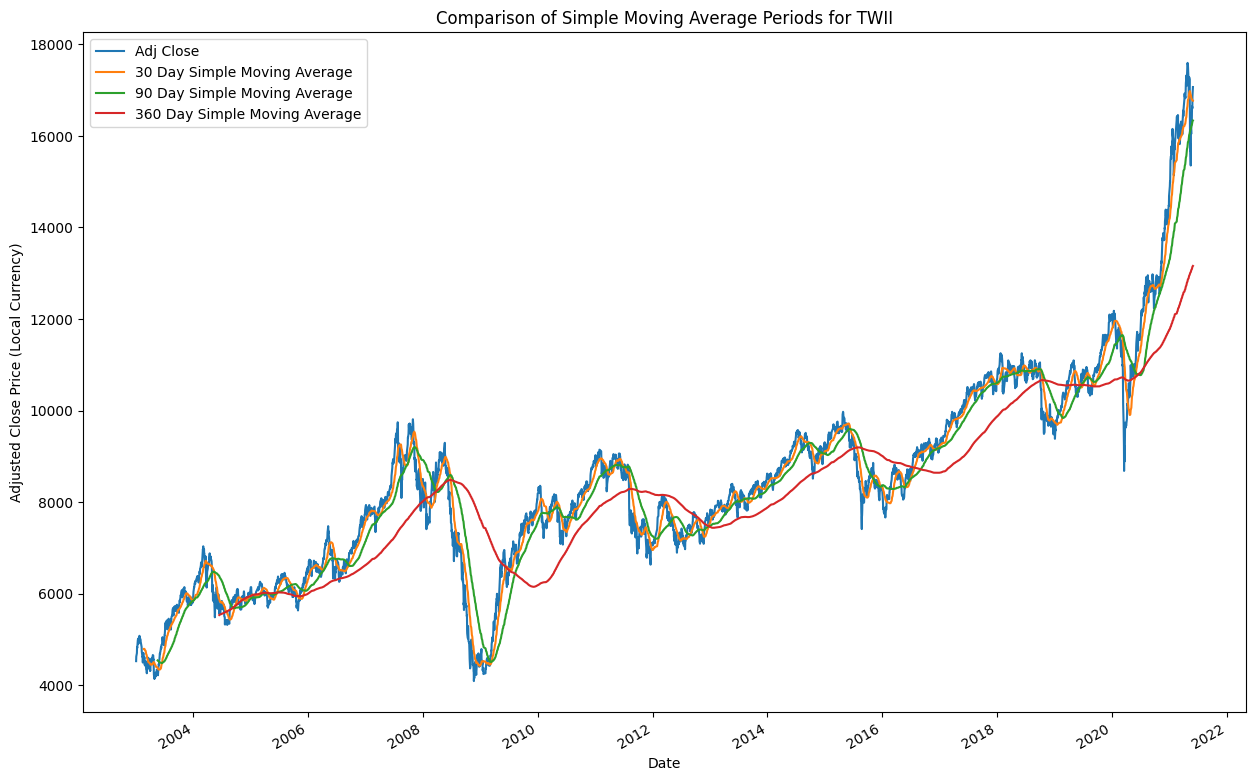

In [167]:
# Calculate simple moving averages for each index.
for index in data_frames_per_index.keys():
    # Increasing the window size smooths the data, but reduces the accuracy.
    data_frames_per_index[index]["30 Day Simple Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].rolling(30, min_periods=30).mean()
    )
    data_frames_per_index[index]["90 Day Simple Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].rolling(90, min_periods=90).mean()
    )
    data_frames_per_index[index]["360 Day Simple Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].rolling(360, min_periods=360).mean()
    )

# Generate a time series graph for each index.
for index in data_frames_per_index.keys():
    data_frames_per_index[index].plot(
        x="Date",
        y=[
            "Adj Close",
            "30 Day Simple Moving Average",
            "90 Day Simple Moving Average",
            "360 Day Simple Moving Average",
        ],
        xlabel="Date",
        ylabel="Adjusted Close Price (Local Currency)",
        title=f"Comparison of Simple Moving Average Periods for {index}",
        figsize=(15, 10),
    )


### Calculate Exponential Moving Averages


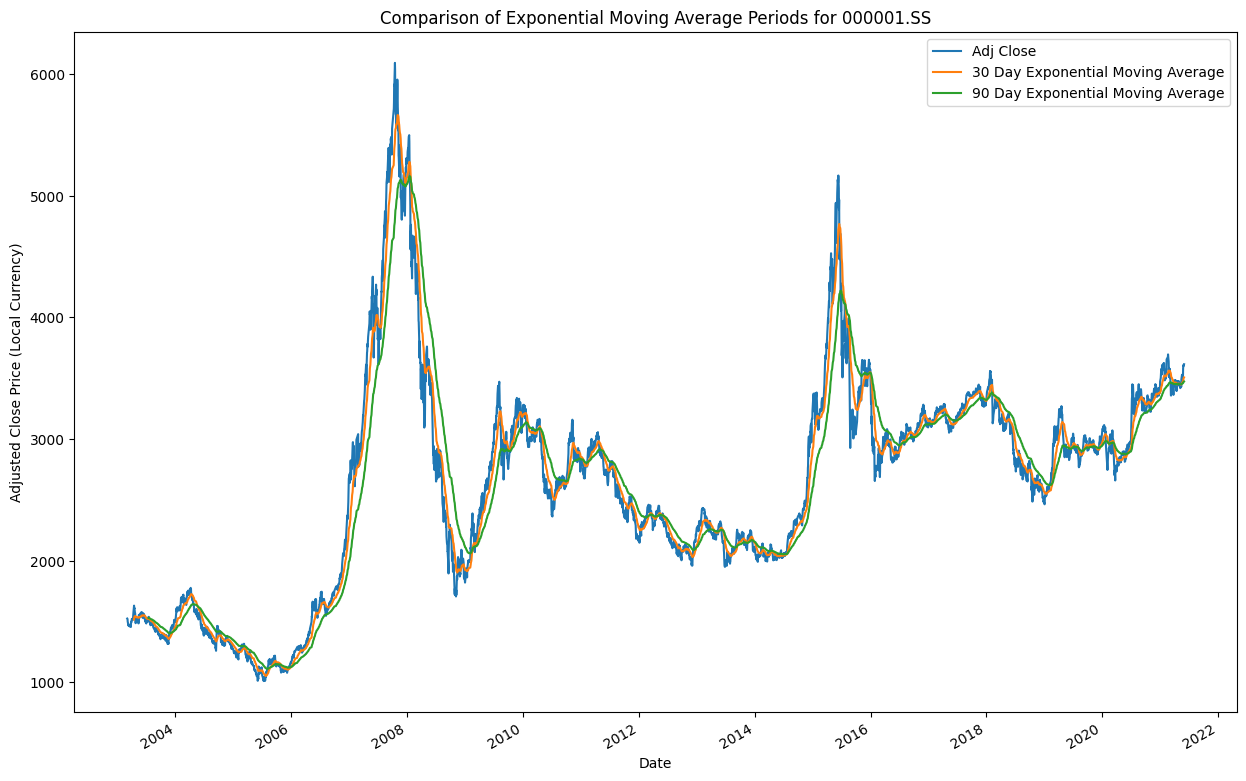

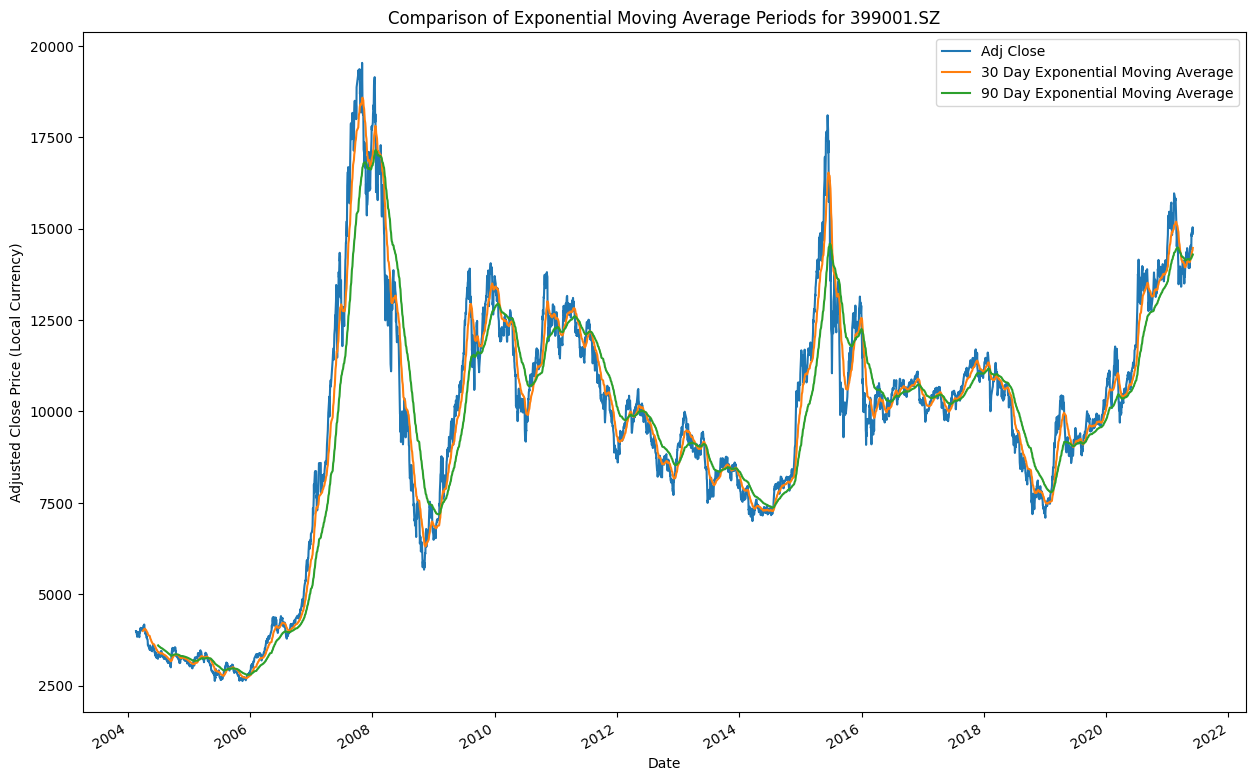

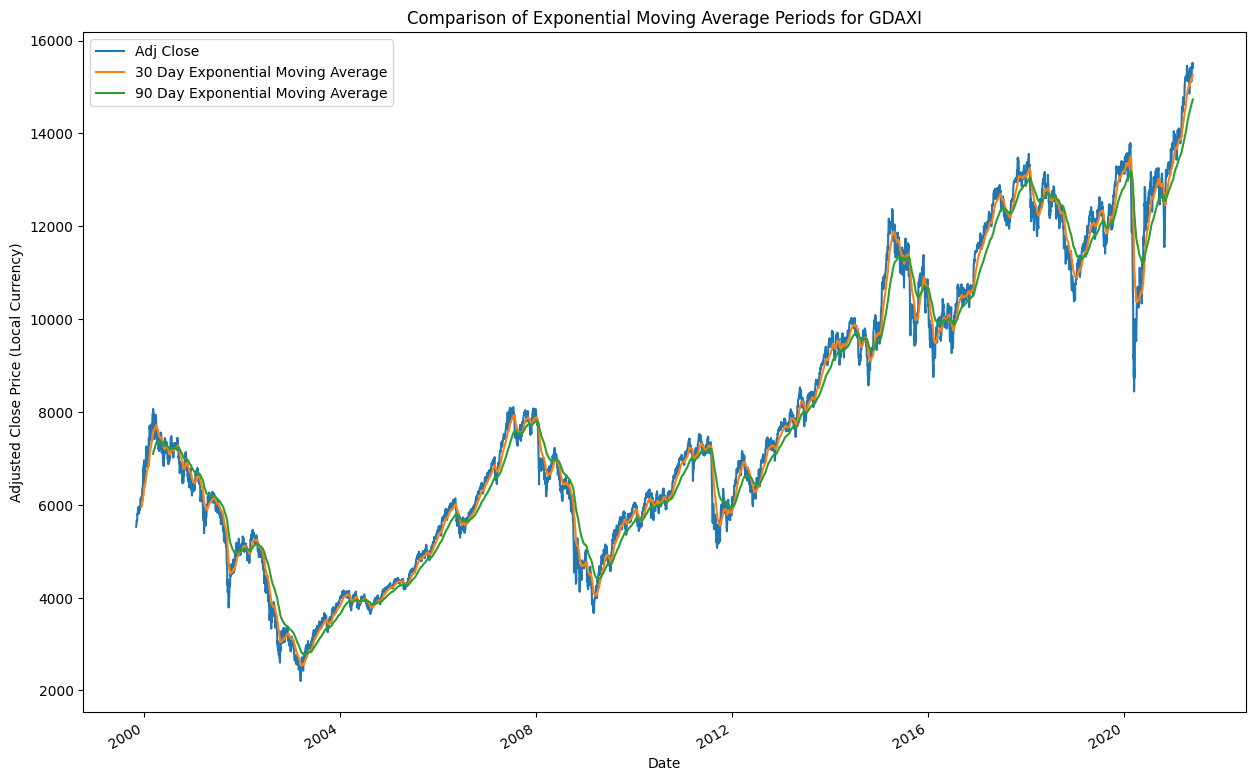

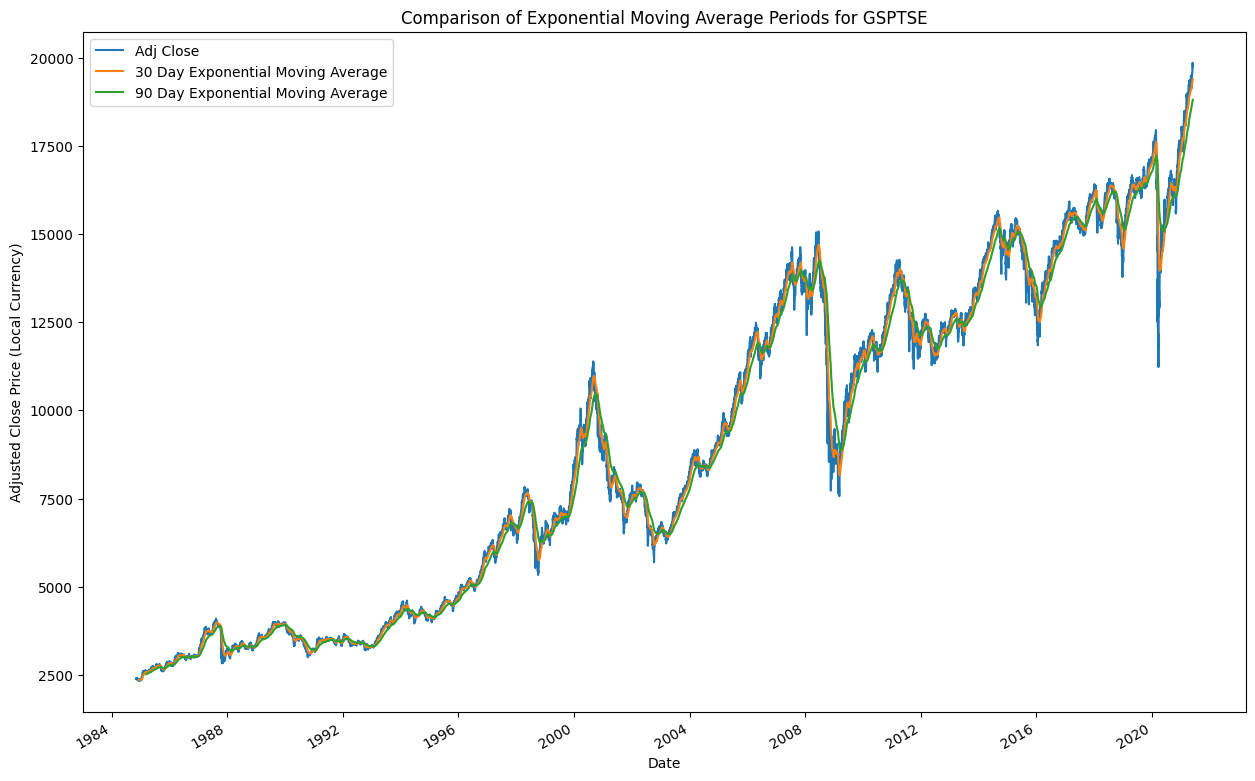

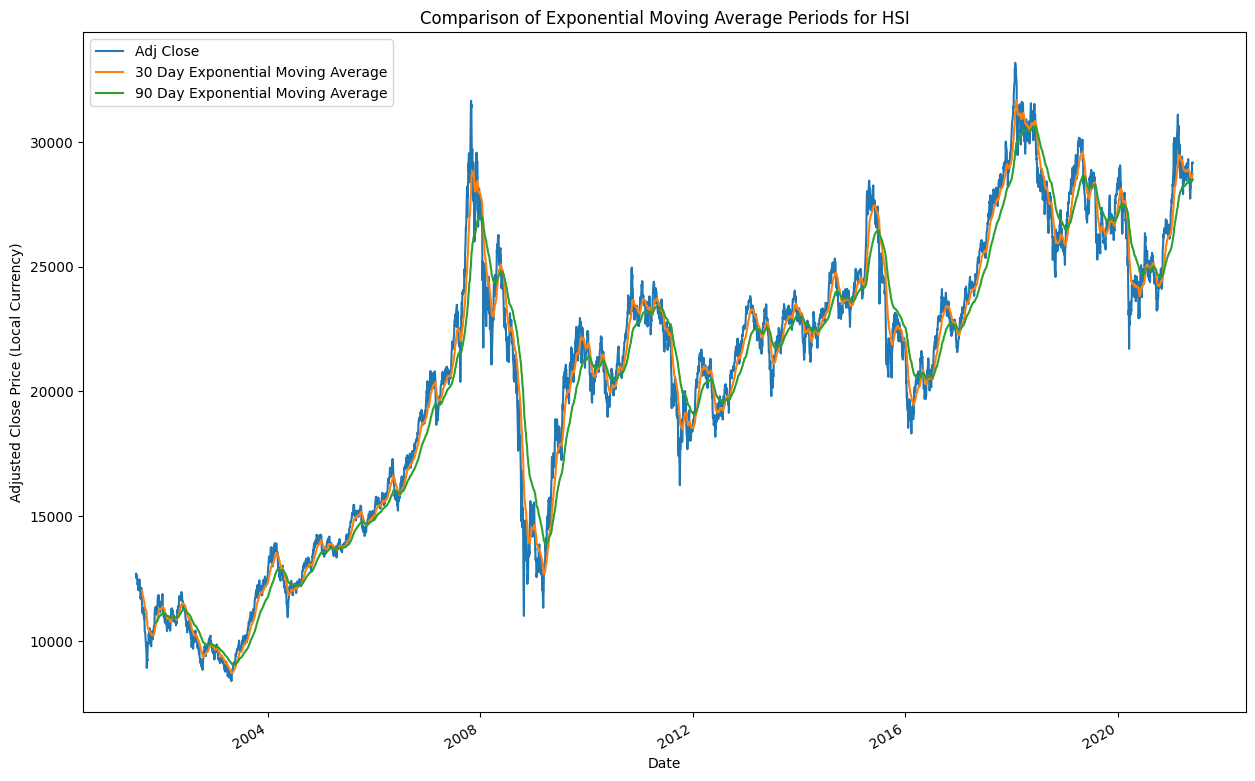

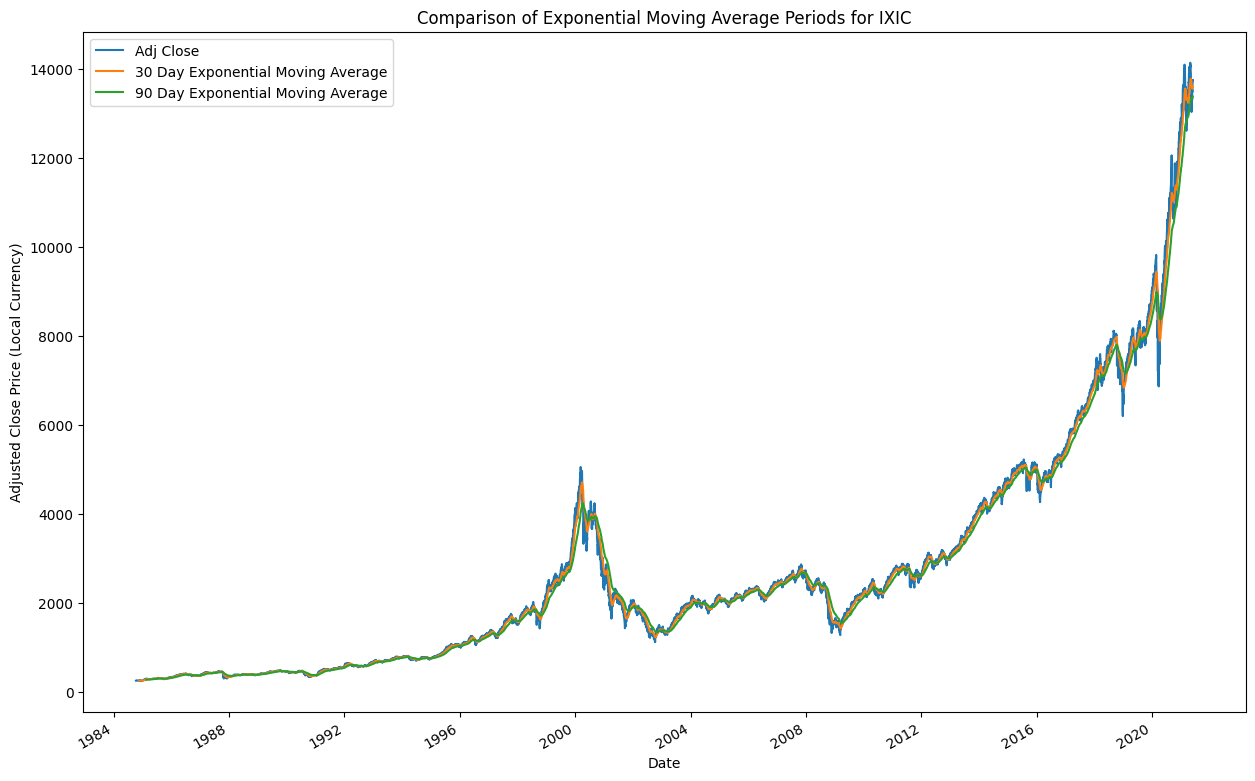

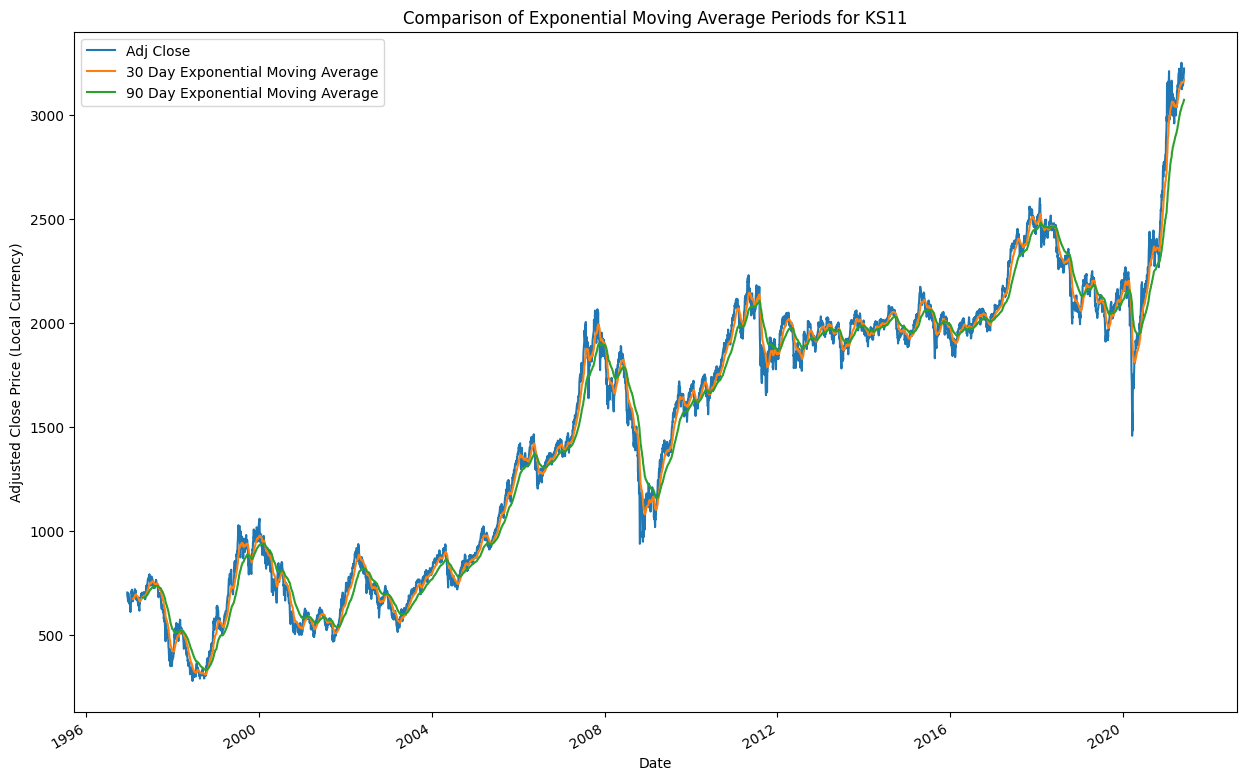

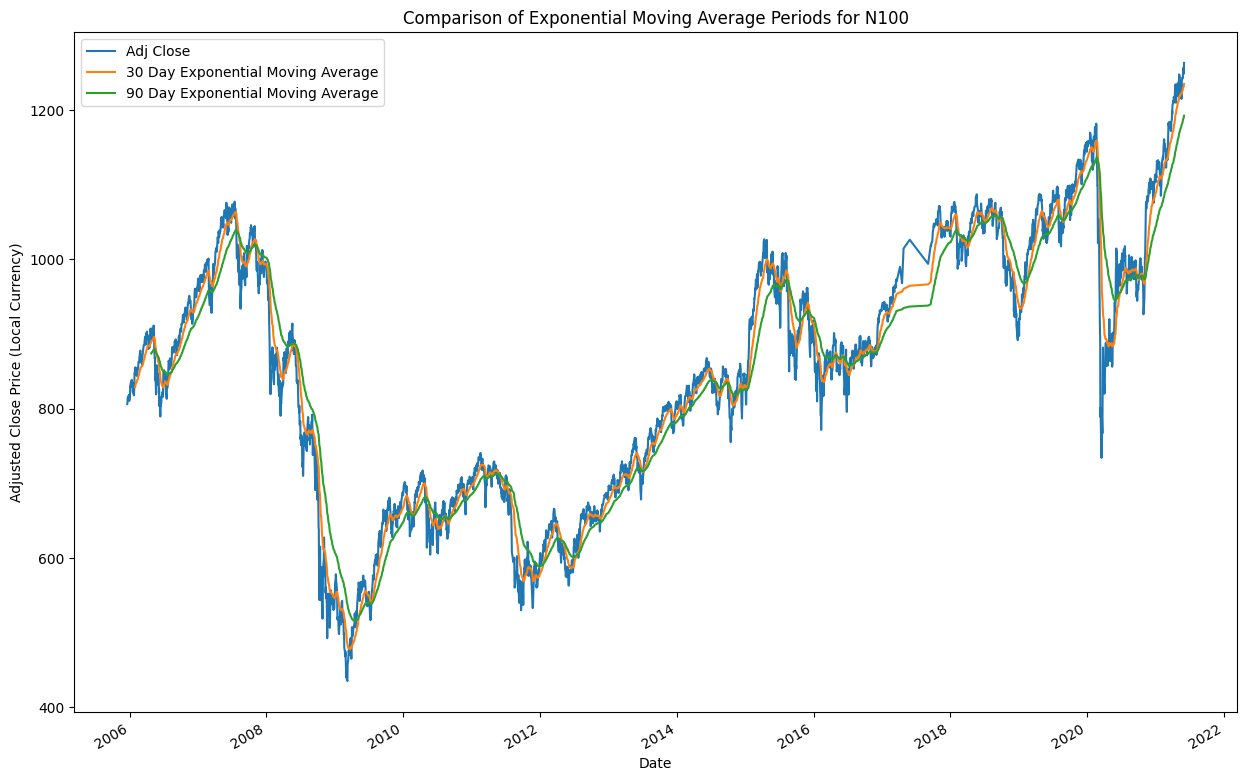

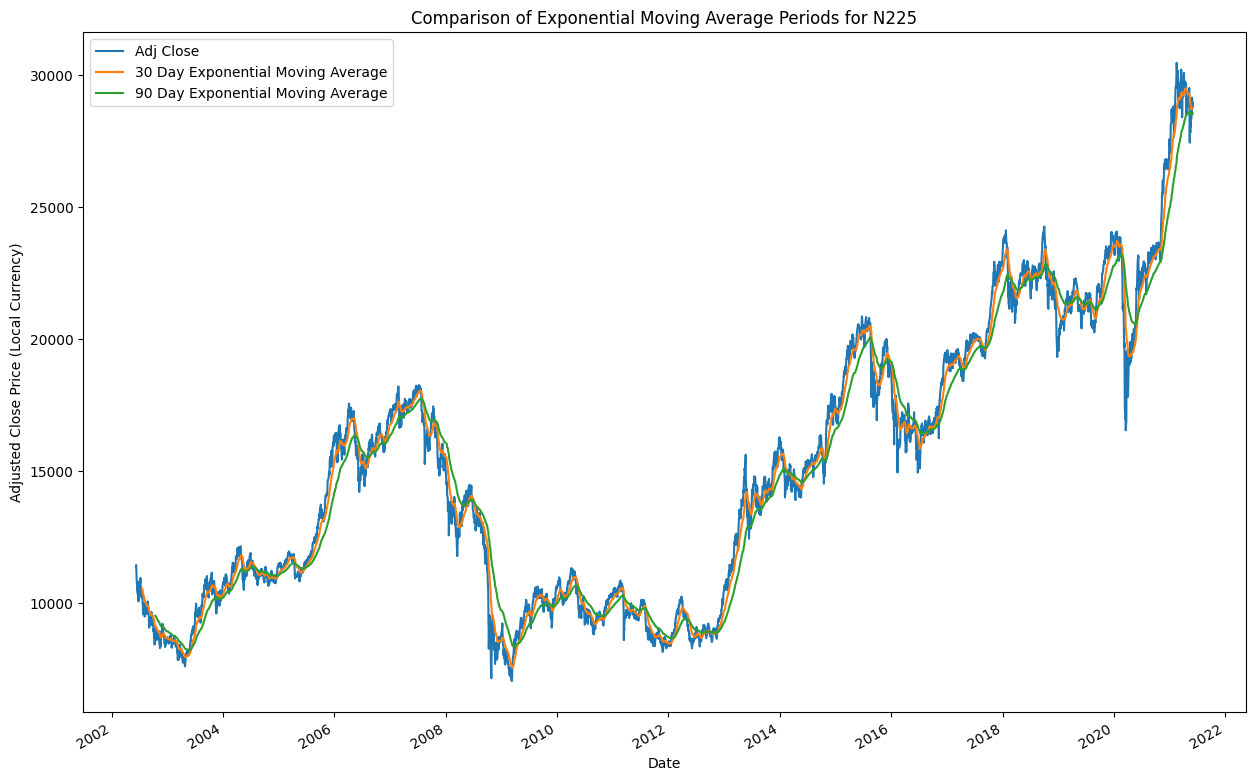

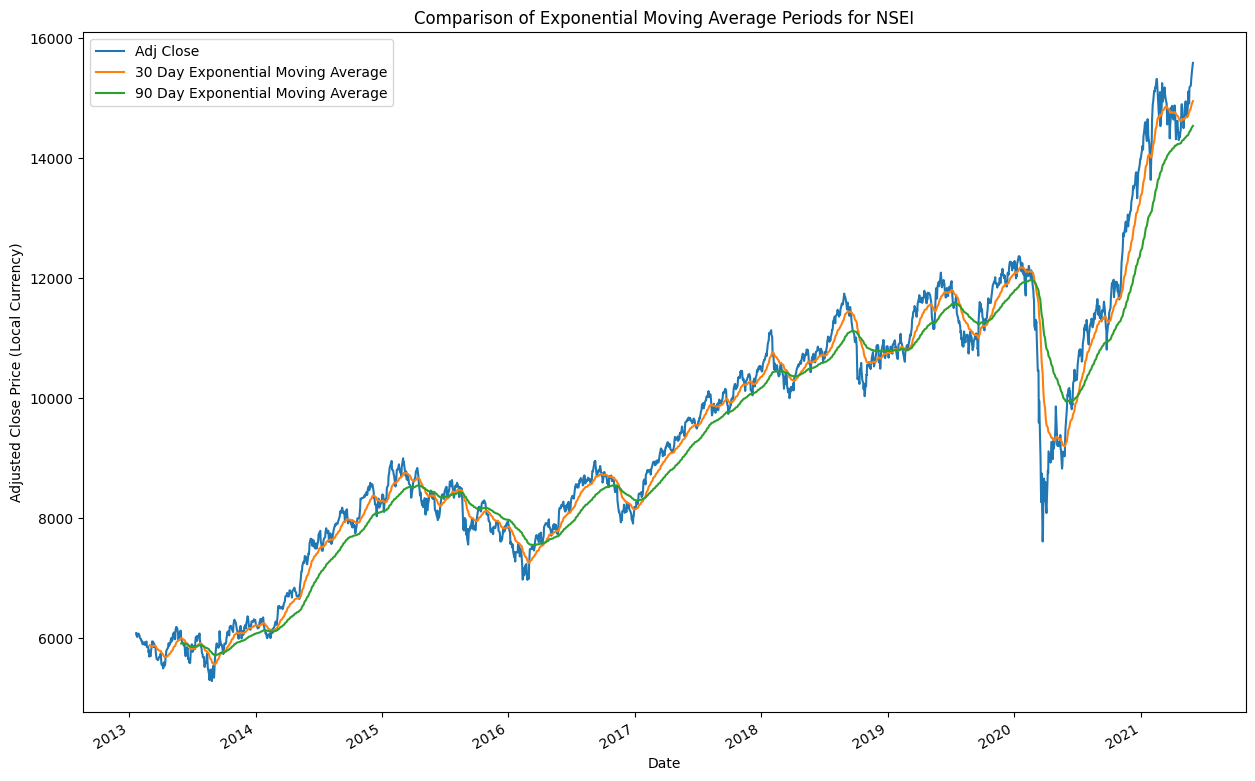

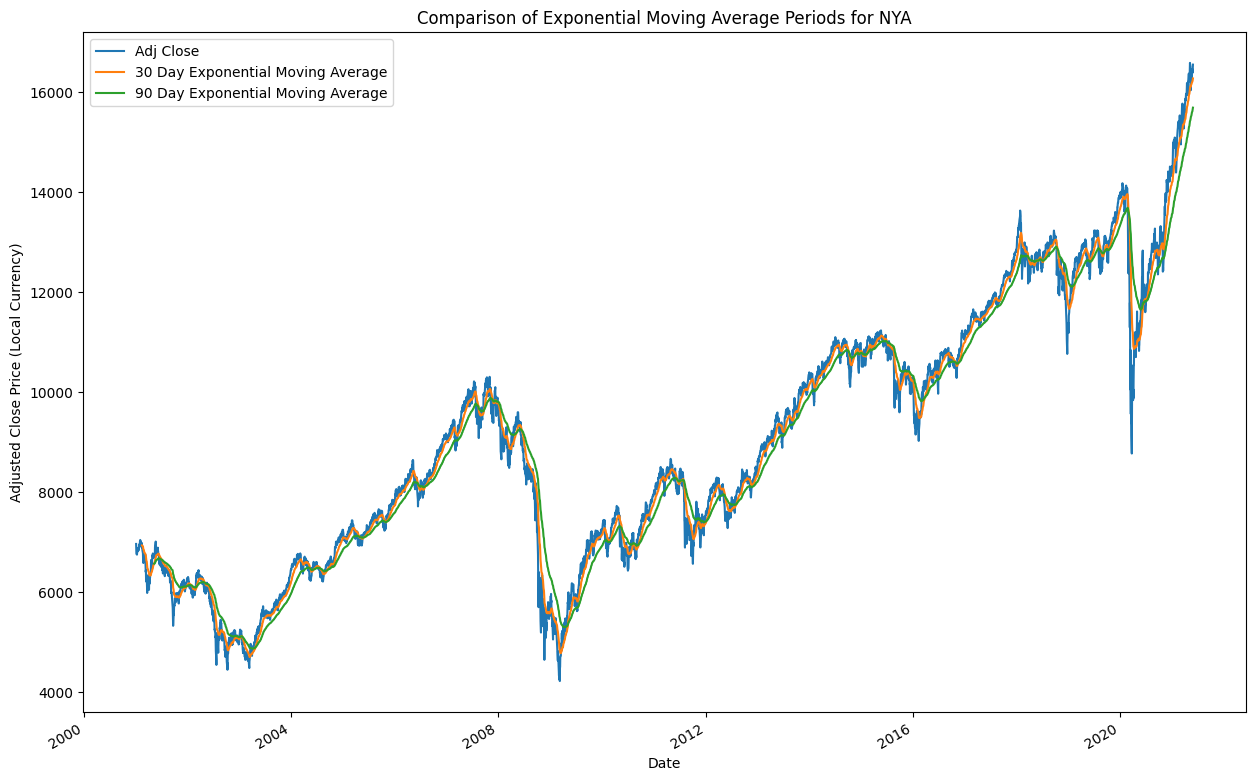

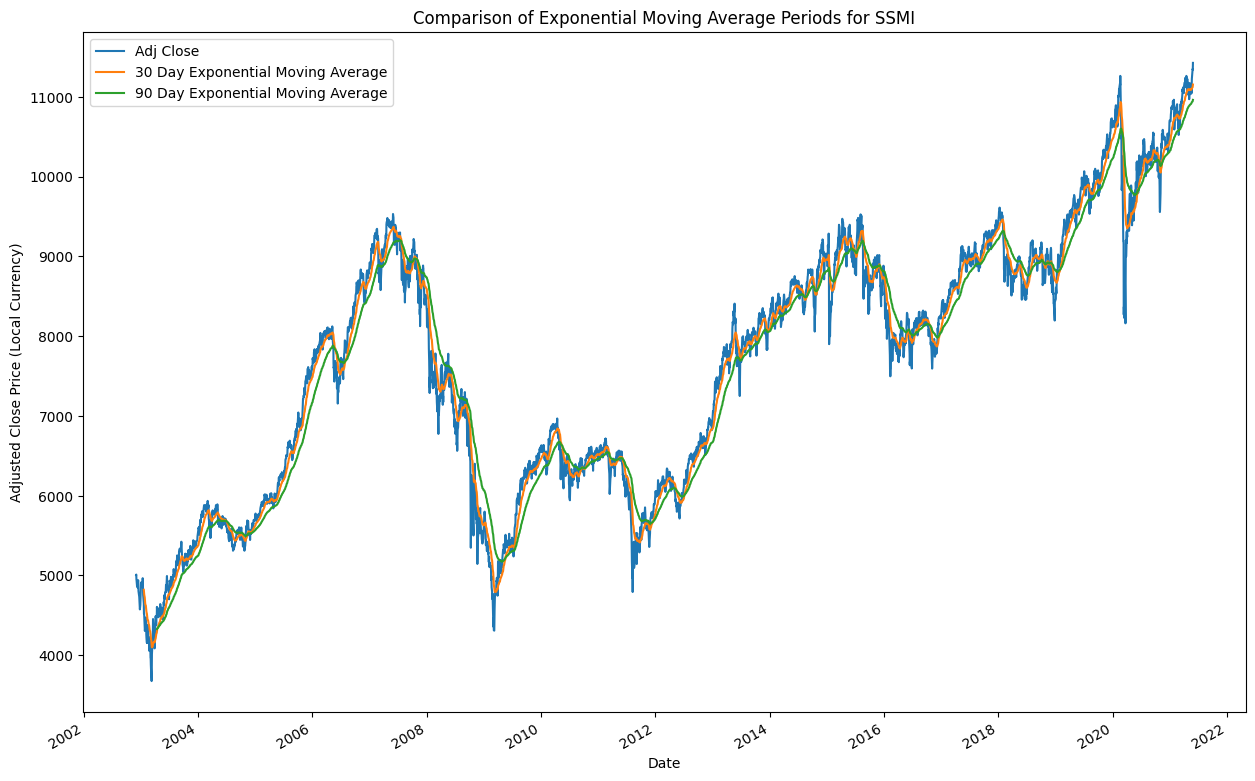

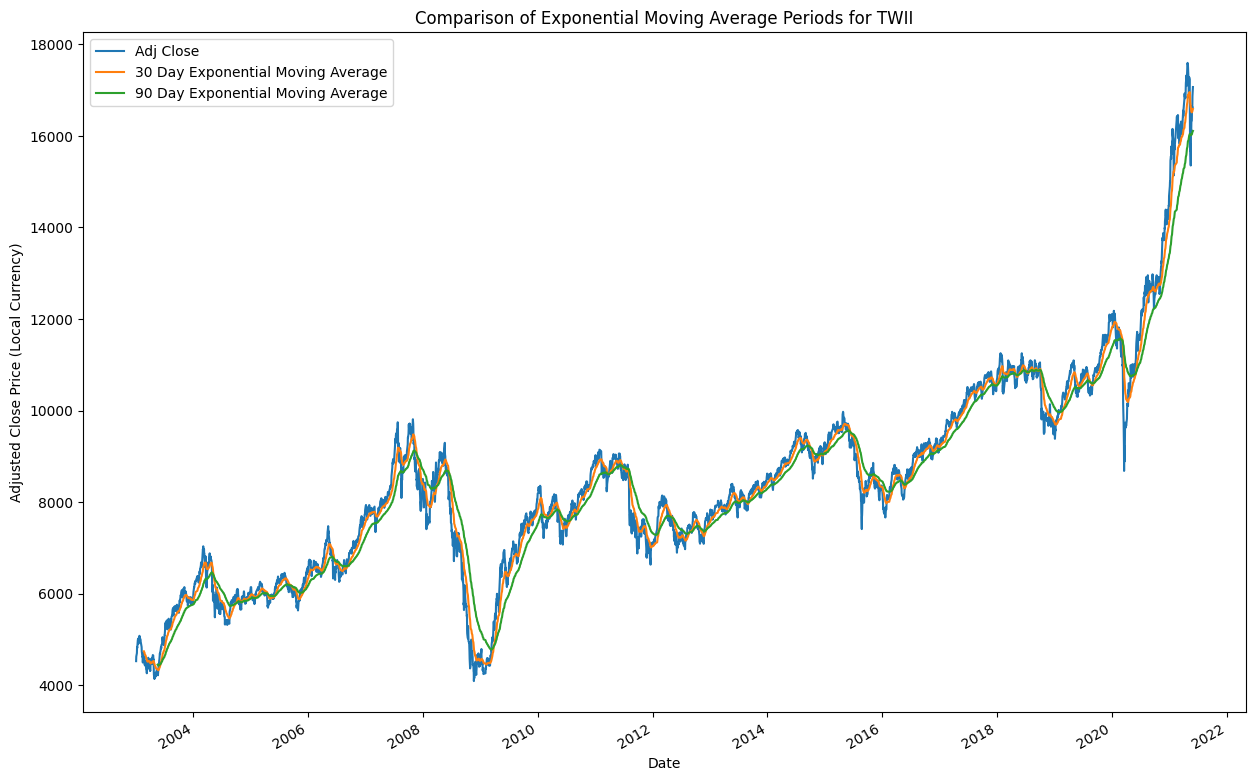

In [168]:
for index in data_frames_per_index.keys():
    # Calculate 30 and 90 day exponential moving averages for each index.
    data_frames_per_index[index]["30 Day Exponential Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].ewm(span=30, min_periods=30).mean()
    )
    data_frames_per_index[index]["90 Day Exponential Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].ewm(span=90, min_periods=90).mean()
    )

# Generate a time series graph for each index.
for index in data_frames_per_index.keys():
    data_frames_per_index[index].plot(
        x="Date",
        y=[
            "Adj Close",
            "30 Day Exponential Moving Average",
            "90 Day Exponential Moving Average",
        ],
        xlabel="Date",
        ylabel="Adjusted Close Price (Local Currency)",
        title=f"Comparison of Exponential Moving Average Periods for {index}",
        figsize=(15, 10),
    )


## Data Filtering


### Select Moving Average Strategy


<AxesSubplot: title={'center': 'Comparison of Moving Average Strategies for Nasdaq Composite (IXIC) - Last 5 Years'}, xlabel='Date', ylabel='Adjusted Close Price (USD)'>

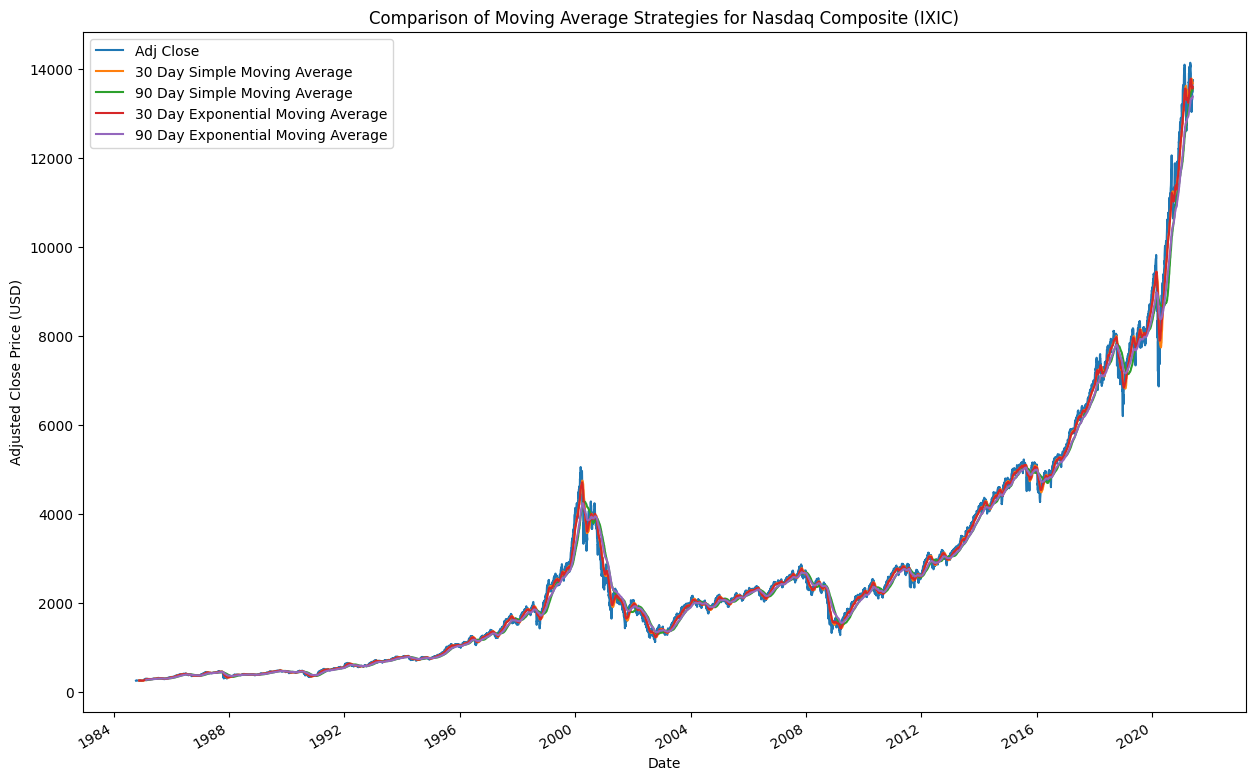

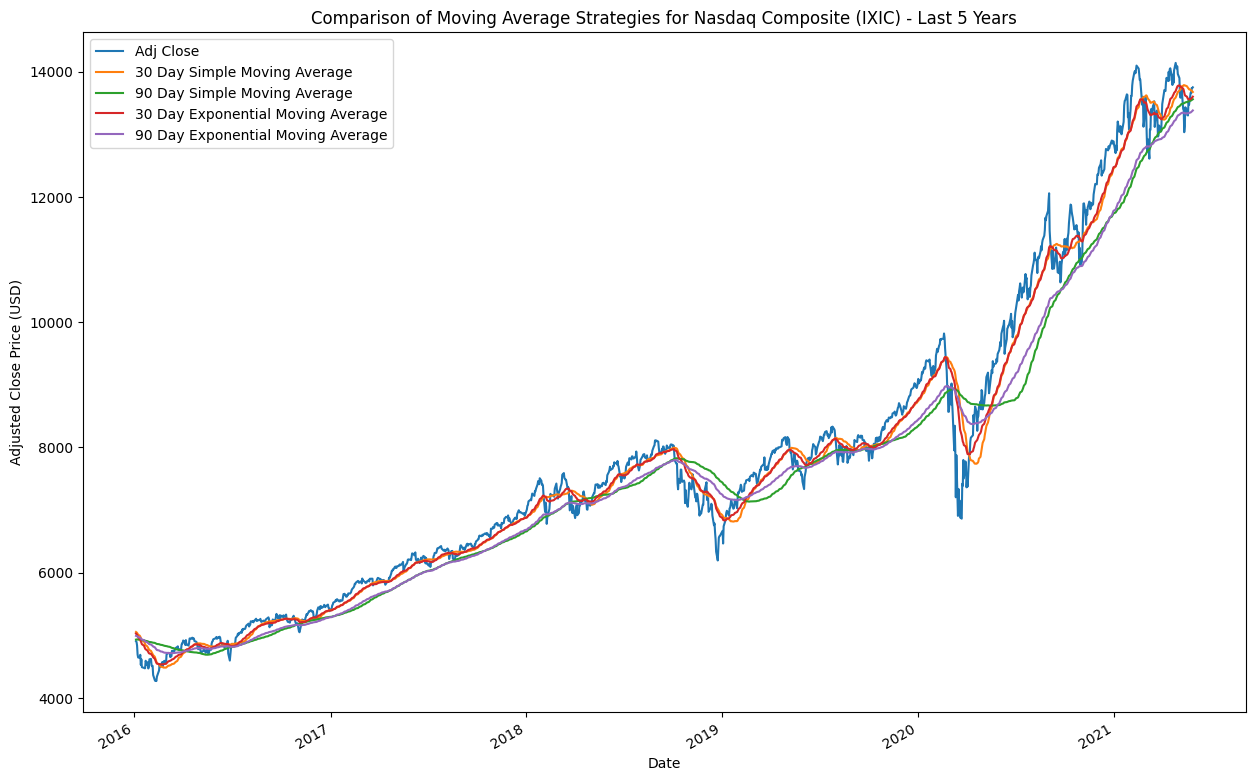

In [169]:
# Plot the IXIC data to compare how the moving average strategies perform.
ixic_data.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Simple Moving Average",
        "90 Day Simple Moving Average",
        "30 Day Exponential Moving Average",
        "90 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Comparison of Moving Average Strategies for Nasdaq Composite (IXIC)",
    figsize=(15, 10),
)

# Plot the IXIC data from the last five years to zoom into how the moving
# average strategies perform.
ixic_data_last_5y = ixic_data[(ixic_data["Date"] > "2016-01-01")]
ixic_data_last_5y.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Simple Moving Average",
        "90 Day Simple Moving Average",
        "30 Day Exponential Moving Average",
        "90 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Comparison of Moving Average Strategies for Nasdaq Composite (IXIC) - Last 5 Years",
    figsize=(15, 10),
)


### Show Final Data After Preprocessing


<AxesSubplot: title={'center': 'Time Series Graph for Nasdaq Composite (IXIC) - Last 5 Years'}, xlabel='Date', ylabel='Adjusted Close Price (USD)'>

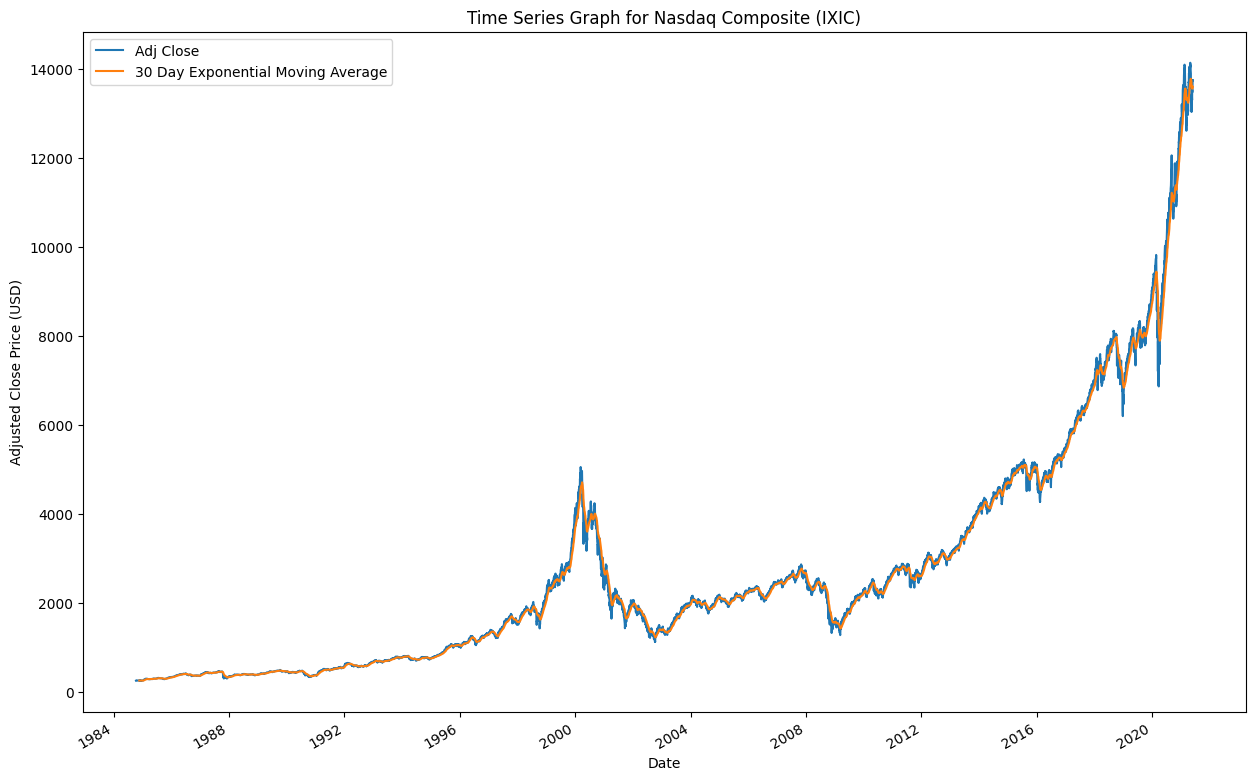

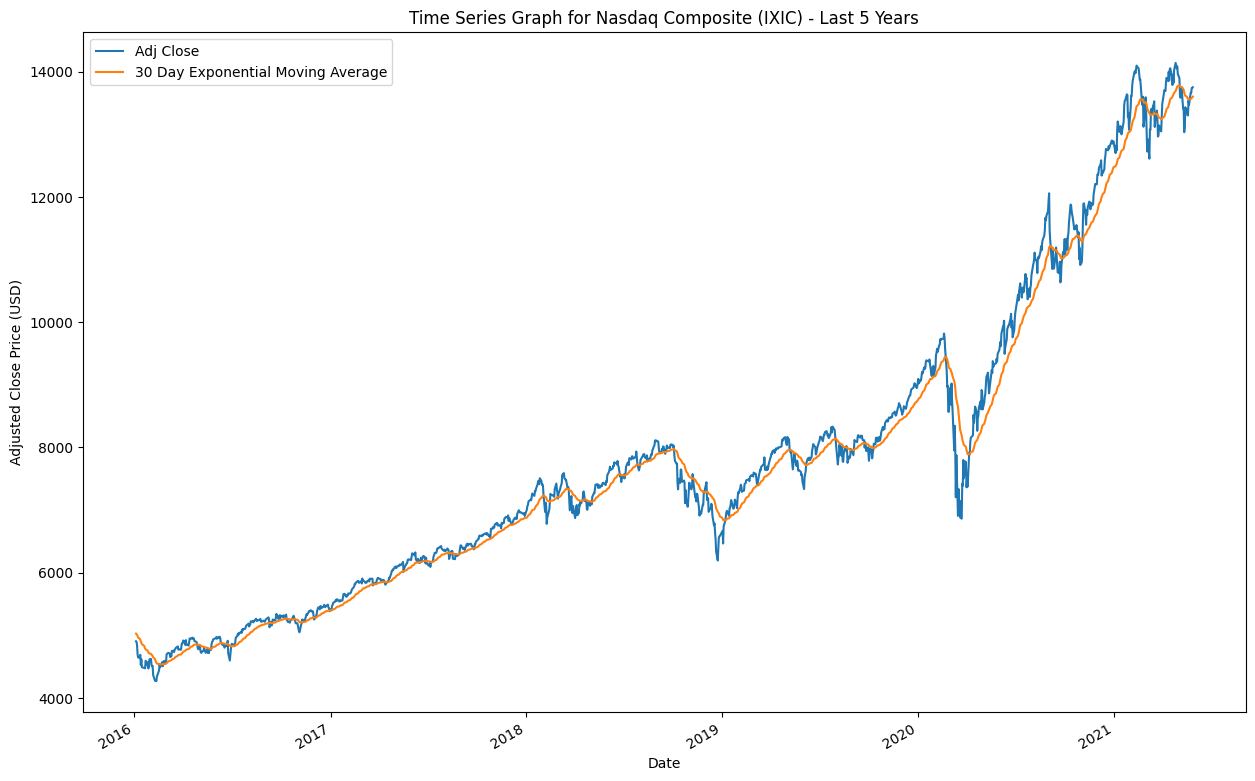

In [170]:
# Plot the IXIC data to show what we're working with.
ixic_data.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Time Series Graph for Nasdaq Composite (IXIC)",
    figsize=(15, 10),
)

# Show a zoomed in view using the last five years of data.
ixic_data_last_5y = ixic_data[ixic_data["Date"] > "2016-01-01"]
# Plot the IXIC data to show what we're working with.
ixic_data_last_5y.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Time Series Graph for Nasdaq Composite (IXIC) - Last 5 Years",
    figsize=(15, 10),
)

## Forecasting with Regression Models


### Generate Training and Test Data Sets for IXIC Index


In [171]:
# # Shift 30 day exponential average to the future by 1 day to exclude the current day's adj close.
ixic_data["30 Day Exponential Moving Average"] = ixic_data[
    "30 Day Exponential Moving Average"
].shift(30)
display(ixic_data)
ixic_data.dropna(inplace=True)
ixic_data.reset_index(drop=True, inplace=True)
display(ixic_data)

x = ixic_data[["30 Day Exponential Moving Average"]]
y = ixic_data[["Adj Close"]]
display(x)
display(y)

# Generate a training and test data set for the IXIC index.
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=False)
# plt.scatter(x_test, y_test)
# x_train = x_train.reshape(-1, 1)
# y_train = y_train.reshape(-1, 1)
# x_test = x_test.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)
print("Training Data:")
display(x_train)
display(y_train)
print("Test Data:")
display(x_test)
display(y_test)

Index       Date          Open          High           Low  \
17405  IXIC 1984-10-11    244.199997    244.699997    244.199997   
17406  IXIC 1984-10-12    245.500000    246.199997    245.500000   
17407  IXIC 1984-10-15    246.800003    247.699997    246.800003   
17408  IXIC 1984-10-16    247.800003    247.899994    247.100006   
17409  IXIC 1984-10-17    247.100006    247.100006    246.800003   
...     ...        ...           ...           ...           ...   
26633  IXIC 2021-05-24  13557.209960  13708.849610  13551.009770   
26634  IXIC 2021-05-25  13721.540040  13751.139650  13631.799810   
26635  IXIC 2021-05-26  13693.940430  13750.160160  13679.589840   
26636  IXIC 2021-05-27  13742.589840  13776.519530  13701.629880   
26637  IXIC 2021-05-28  13792.049810  13820.870120  13747.610350   

              Close     Adj Close        Volume  30 Day Simple Moving Average  \
17405    244.699997    244.699997  6.286000e+07                           NaN   
17406    246.199997    246.199997  5.886000e+07                           NaN   
17407    247.699997    247.699997  6.182000e+07                           NaN   
17408    247.300003    247.300003  5.744000e+07                           NaN   
17409    247.100006    247.100006  6.467000e+07                           NaN   
...             ...           ...           ...                           ...   
26633  13661.169920  13661.169920  3.490650e+09                  13709.372265   
26634  13657.169920  13657.169920  4.084480e+09                  13698.074609   
26635  13738.000000  13738.000000  4.231140e+09                  13694.079948   
26636  13736.280270  13736.280270  5.057550e+09                  13683.997298   
26637  13748.740230  13748.740230  4.435220e+09                  13673.877311   

       90 Day Simple Moving Average  360 Day Simple Moving Average  \
17405                           NaN                            NaN   
17406                           NaN                            NaN   
17407                           NaN                            NaN   
17408                           NaN                            NaN   
17409                           NaN                            NaN   
...                             ...                            ...   
26633                  13534.521864                   11064.832267   
26634                  13540.572201                   11078.247350   
26635                  13548.788867                   11091.721739   
26636                  13554.778874                   11105.086518   
26637                  13558.017654                   11118.428434   

       30 Day Exponential Moving Average  90 Day Exponential Moving Average  
17405                                NaN                                NaN  
17406                                NaN                                NaN  
17407                                NaN                                NaN  
17408                                NaN                                NaN  
17409                                NaN                                NaN  
...                                  ...                                ...  
26633                       13430.406332                       13347.210109  
26634                       13466.902673                       13354.022413  
26635                       13492.124426                       13362.461481  
26636                       13527.391222                       13370.677278  
26637                       13561.258875                       13378.986354  

[9233 rows x 13 columns]

Index       Date          Open          High           Low         Close  \
0     IXIC 1986-03-17    370.200012    371.899994    369.200012    370.000000   
1     IXIC 1986-03-18    371.000000    371.500000    370.000000    371.500000   
2     IXIC 1986-03-19    372.399994    372.700012    371.500000    371.700012   
3     IXIC 1986-03-20    372.700012    372.799988    371.700012    372.700012   
4     IXIC 1986-03-21    373.100006    373.600006    372.200012    372.600006   
...    ...        ...           ...           ...           ...           ...   
8869  IXIC 2021-05-24  13557.209960  13708.849610  13551.009770  13661.169920   
8870  IXIC 2021-05-25  13721.540040  13751.139650  13631.799810  13657.169920   
8871  IXIC 2021-05-26  13693.940430  13750.160160  13679.589840  13738.000000   
8872  IXIC 2021-05-27  13742.589840  13776.519530  13701.629880  13736.280270   
8873  IXIC 2021-05-28  13792.049810  13820.870120  13747.610350  13748.740230   

         Adj Close        Volume  30 Day Simple Moving Average  \
0       370.000000  1.295000e+08                    354.848331   
1       371.500000  1.395000e+08                    355.981664   
2       371.700012  1.369000e+08                    357.108331   
3       372.700012  1.514000e+08                    358.234999   
4       372.600006  1.329000e+08                    359.294999   
...            ...           ...                           ...   
8869  13661.169920  3.490650e+09                  13709.372265   
8870  13657.169920  4.084480e+09                  13698.074609   
8871  13738.000000  4.231140e+09                  13694.079948   
8872  13736.280270  5.057550e+09                  13683.997298   
8873  13748.740230  4.435220e+09                  13673.877311   

      90 Day Simple Moving Average  360 Day Simple Moving Average  \
0                       331.131666                     291.035139   
1                       331.962777                     291.387361   
2                       332.787222                     291.735972   
3                       333.595000                     292.083195   
4                       334.376111                     292.431250   
...                            ...                            ...   
8869                  13534.521864                   11064.832267   
8870                  13540.572201                   11078.247350   
8871                  13548.788867                   11091.721739   
8872                  13554.778874                   11105.086518   
8873                  13558.017654                   11118.428434   

      30 Day Exponential Moving Average  90 Day Exponential Moving Average  
0                            326.637225                         334.800629  
1                            327.338049                         335.607473  
2                            328.019465                         336.400970  
3                            328.721435                         337.199002  
4                            329.500696                         337.977284  
...                                 ...                                ...  
8869                       13430.406332                       13347.210109  
8870                       13466.902673                       13354.022413  
8871                       13492.124426                       13362.461481  
8872                       13527.391222                       13370.677278  
8873                       13561.258875                       13378.986354  

[8874 rows x 13 columns]

30 Day Exponential Moving Average
0                            326.637225
1                            327.338049
2                            328.019465
3                            328.721435
4                            329.500696
...                                 ...
8869                       13430.406332
8870                       13466.902673
8871                       13492.124426
8872                       13527.391222
8873                       13561.258875

[8874 rows x 1 columns]

Adj Close
0       370.000000
1       371.500000
2       371.700012
3       372.700012
4       372.600006
...            ...
8869  13661.169920
8870  13657.169920
8871  13738.000000
8872  13736.280270
8873  13748.740230

[8874 rows x 1 columns]

Training Data:


30 Day Exponential Moving Average
0                            326.637225
1                            327.338049
2                            328.019465
3                            328.721435
4                            329.500696
...                                 ...
7094                        4265.667381
7095                        4263.641745
7096                        4257.831315
7097                        4250.953810
7098                        4244.812258

[7099 rows x 1 columns]

Adj Close
0      370.000000
1      371.500000
2      371.700012
3      372.700012
4      372.600006
...           ...
7094  4080.760010
7095  4067.669922
7096  4051.500000
7097  4071.870117
7098  4143.859863

[7099 rows x 1 columns]

Test Data:


30 Day Exponential Moving Average
7099                        4241.855999
7100                        4243.545292
7101                        4245.668819
7102                        4245.157297
7103                        4237.581341
...                                 ...
8869                       13430.406332
8870                       13466.902673
8871                       13492.124426
8872                       13527.391222
8873                       13561.258875

[1775 rows x 1 columns]

Adj Close
7099   4130.169922
7100   4100.629883
7101   4069.290039
7102   4090.590088
7103   4125.810059
...            ...
8869  13661.169920
8870  13657.169920
8871  13738.000000
8872  13736.280270
8873  13748.740230

[1775 rows x 1 columns]

### Ridge Regression


#### Tune Alpha Hyperparameter for Ridge


In [172]:
# Use grid search to perform hyperparameter tuning on the ridge regression
# model.
parameters = [{"alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}]
model = Ridge()
grid_search = GridSearchCV(
    cv=5,
    estimator=model,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)
best_ridge_alpha = grid_search.best_params_["alpha"]
print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best Score: {grid_search.score(x_test, y_test)}")


Best Ridge Alpha: 0.1
Best Score: 0.9499724363550578


#### Predict using Ridge with Best Alpha Parameter


array([[ 4259.46709199],
       [ 4261.15226185],
       [ 4263.27060601],
       ...,
       [13487.1583602 ],
       [13522.33908084],
       [13556.12407273]])

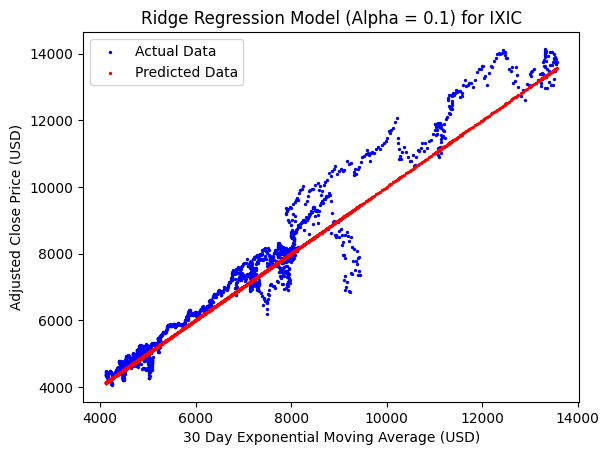

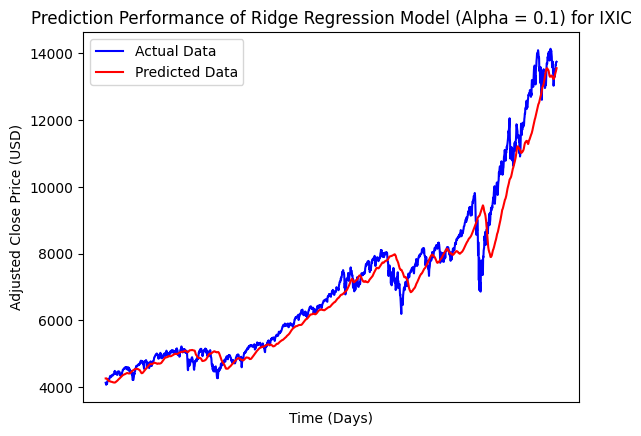

Model Score: 0.9499724363550578
Mean Absolute Error (MAE): 392.50735268102807
Root Mean Squared Error (RMSE): 559.9741592052716


In [173]:
# Define the ridge regression model.
ridge_model = Ridge(alpha=best_ridge_alpha)
ridge_model.fit(x_train, y_train)
y_pred = ridge_model.predict(x_test)
display(y_pred)

# Plot how well the ridge regression model fits the relationship between
# exponential moving average and adjusted close price.
plt.scatter(x_test, y_test, s=2, color="blue", label="Actual Data")
plt.scatter(x_test, y_pred, s=2, color="red", label="Predicted Data")
plt.xlabel("30 Day Exponential Moving Average (USD)")
plt.ylabel("Adjusted Close Price (USD)")
plt.title(f"Ridge Regression Model (Alpha = {best_ridge_alpha}) for IXIC")
plt.legend()
plt.show()

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["Adj Close"]).reshape(-1, 1)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.xlabel("Time (Days)")
plt.ylabel("Adjusted Close Price (USD)")
# TODO: Add test dates (last 20% of data) to x-ticks.
# test_dates = ixic_data["Date"].tail(len(y_test_vals)).values
# plt.xticks([np.datetime64(val).astype(datetime) for val in test_dates])
# plt.xticks([val for val in ixic_data["Date"].tail(len(y_test_vals))])
plt.xticks([])
plt.title(
    f"Prediction Performance of Ridge Regression Model (Alpha = {best_ridge_alpha}) "
    "for IXIC"
)
plt.legend()
plt.show()

print(f"Model Score: {ridge_model.score(x_test, y_test)}")
print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred)}")
print(
    f"Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}"
)


### LASSO Regression

#### Tune Alpha Hyperparameter for LASSO


In [174]:
# Use grid search to perform hyperparameter tuning on the LASSO regression
# model.
parameters = [{"alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}]
model = Lasso()
grid_search = GridSearchCV(
    cv=5,
    estimator=model,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)
best_lasso_alpha = grid_search.best_params_["alpha"]
print(f"Best LASSO Alpha: {best_lasso_alpha}")
print(f"Best Score: {grid_search.score(x_test, y_test)}")


Best LASSO Alpha: 0.1
Best Score: 0.949972389107981


#### Predict Using LASSO with Optimal Alpha Parameter


array([ 4259.46684527,  4261.15201497,  4263.27035892, ...,
       13487.15722883, 13522.3379461 , 13556.12293475])

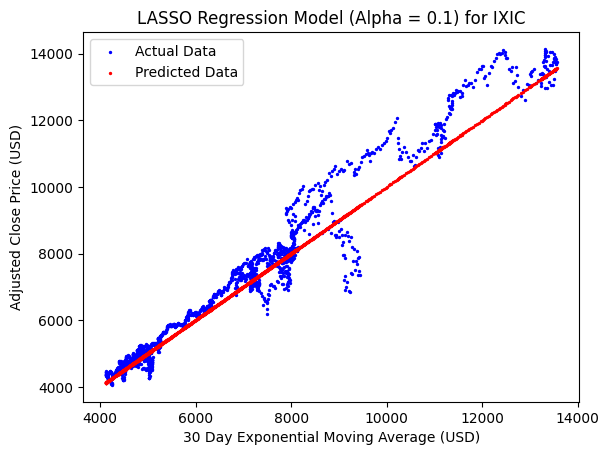

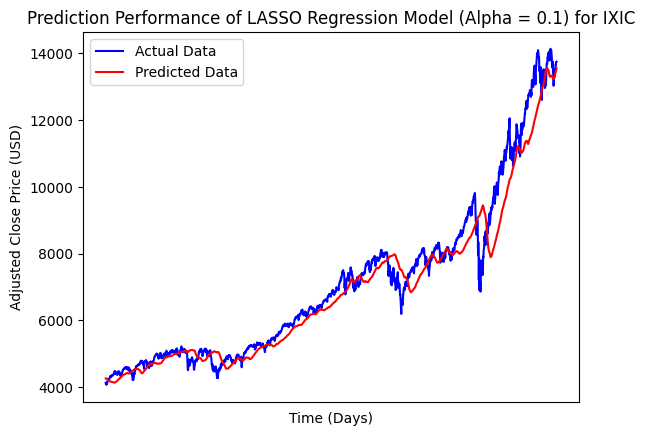

Model Score: 0.949972389107981
Mean Absolute Error (MAE): 392.50763009979676
Root Mean Squared Error (RMSE): 559.9744236308596


In [175]:
# Define the LASSO regression model.
lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(x_train, y_train)
y_pred = lasso_model.predict(x_test)
display(y_pred)

# Plot how well the LASSO regression model fits the relationship between
# exponential moving average and adjusted close price.
plt.scatter(x_test, y_test, s=2, color="blue", label="Actual Data")
plt.scatter(x_test, y_pred, s=2, color="red", label="Predicted Data")
plt.xlabel("30 Day Exponential Moving Average (USD)")
plt.ylabel("Adjusted Close Price (USD)")
plt.title(f"LASSO Regression Model (Alpha = {best_lasso_alpha}) for IXIC")
plt.legend()
plt.show()

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["Adj Close"]).reshape(-1, 1)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.xlabel("Time (Days)")
plt.ylabel("Adjusted Close Price (USD)")
# TODO: Add test dates (last 20% of data) to x-ticks.
# test_dates = ixic_data["Date"].tail(len(y_test_vals)).values
# plt.xticks([np.datetime64(val).astype(datetime) for val in test_dates])
# plt.xticks([val for val in ixic_data["Date"].tail(len(y_test_vals))])
plt.xticks([])
plt.title(
    f"Prediction Performance of LASSO Regression Model (Alpha = {best_lasso_alpha}) "
    "for IXIC"
)
plt.legend()
plt.show()

print(f"Model Score: {lasso_model.score(x_test, y_test)}")
print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred)}")
print(
    f"Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}"
)


### Polynomial Regression

#### Tune Poly Degree Hyperparameter for Polynomial

In [176]:
# Use grid search to perform hyperparameter tuning on the polynomial regression
# model.
parameters = [{"poly__degree": [2, 3, 4, 5, 6, 7, 8, 9, 10]}]
pipeline = Pipeline(
    steps=[
        ("poly", PolynomialFeatures()),
        ("linear", LinearRegression()),
    ]
)
grid_search = GridSearchCV(
    cv=5,
    estimator=pipeline,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)
best_poly_degree = grid_search.best_params_["poly__degree"]
print(f"Best Polynomial Degree: {best_poly_degree}")
print(f"Best Score: {grid_search.score(x_test, y_test)}")


Best Polynomial Degree: 2
Best Score: 0.7527729325848969


#### Predict Using Polynomial with Optimal Degree


array([[ 4165.16791584],
       [ 4166.68486833],
       [ 4168.59158385],
       ...,
       [10666.44339646],
       [10684.31942422],
       [10701.43684636]])

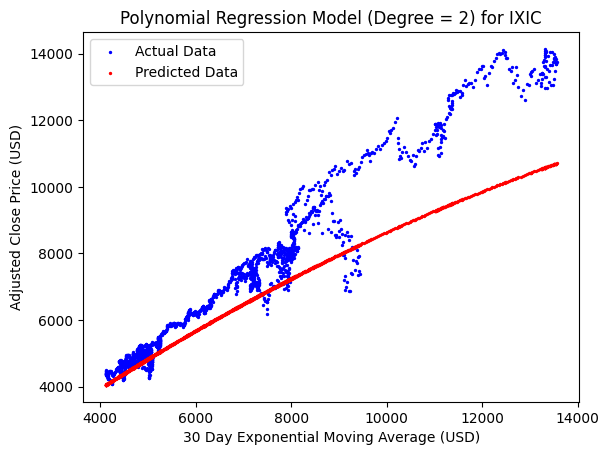

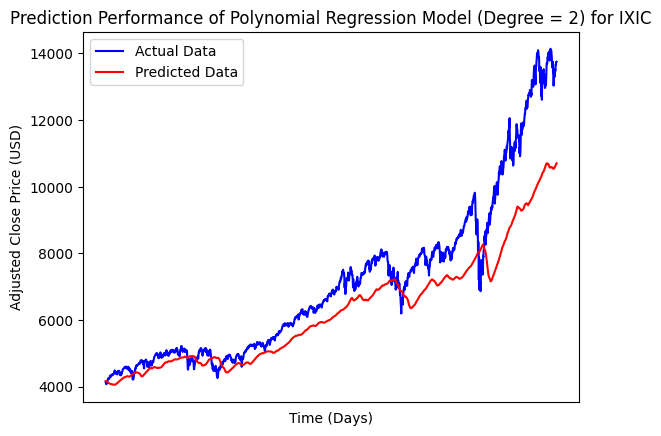

Model Score: 0.7527729325848969
Mean Absolute Error (MAE): 883.191319745268
Root Mean Squared Error (RMSE): 1244.8336468394023


In [177]:
# Fit polynomial regression with degree 2 to the dataset.
poly_reg_deg_2 = PolynomialFeatures(degree=best_poly_degree)
x_train_poly = poly_reg_deg_2.fit_transform(x_train)

# Define the polynomial regression model.
poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
x_test_poly = poly_reg_deg_2.fit_transform(x_test)
y_pred = poly_model.predict(x_test_poly)
display(y_pred)

# Plot how well the polynomial regression model fits the relationship between
# exponential moving average and adjusted close price.
plt.scatter(x_test, y_test, s=2, color="blue", label="Actual Data")
plt.scatter(x_test, y_pred, s=2, color="red", label="Predicted Data")
plt.xlabel("30 Day Exponential Moving Average (USD)")
plt.ylabel("Adjusted Close Price (USD)")
plt.title(f"Polynomial Regression Model (Degree = {best_poly_degree}) for IXIC")
plt.legend()
plt.show()

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["Adj Close"]).reshape(-1, 1)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.xlabel("Time (Days)")
plt.ylabel("Adjusted Close Price (USD)")
# TODO: Add test dates (last 20% of data) to x-ticks.
# test_dates = ixic_data["Date"].tail(len(y_test_vals)).values
# plt.xticks([np.datetime64(val).astype(datetime) for val in test_dates])
# plt.xticks([val for val in ixic_data["Date"].tail(len(y_test_vals))])
plt.xticks([])
plt.title(
    "Prediction Performance of Polynomial Regression Model "
    f"(Degree = {best_poly_degree}) for IXIC"
)
plt.legend()
plt.show()

print(f"Model Score: {poly_model.score(x_test_poly, y_test)}")
print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred)}")
print(
    f"Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}"
)


## Discussion of Results


### Comparison to Naive Benchmark

Naive Benchmark R^2 Score: 0.9887038438093156
Naive Benchmark MAE: 155.81090510425145
Naive Benchmark RMSE: 277.7004089121447


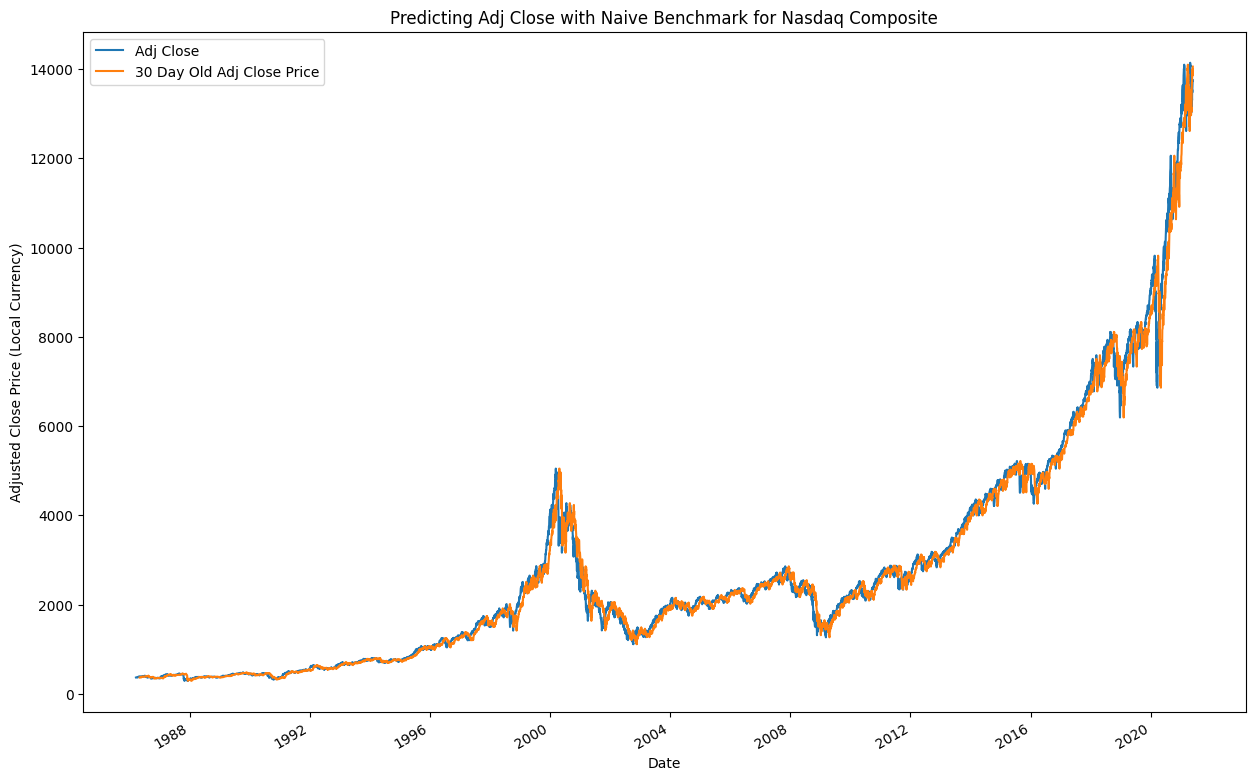

In [178]:
# Use 30 day old price as the prediction for that day.
data_frames_per_index["IXIC"]["30 Day Old Adj Close Price"] = data_frames_per_index[
    "IXIC"
]["Adj Close"].shift(30)

# Visualise how well the naive benchmark predicts prices 30 days in advance.
data_frames_per_index["IXIC"].plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Old Adj Close Price",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (Local Currency)",
    title=f"Predicting Adj Close with Naive Benchmark for Nasdaq Composite",
    figsize=(15, 10),
)

# Remove values that are NaN.
data_frames_per_index["IXIC"] = data_frames_per_index["IXIC"].dropna()

# Calculate R^2 score for the naive benchmark.
naive_r2_score = metrics.r2_score(
    data_frames_per_index["IXIC"]["Adj Close"],
    data_frames_per_index["IXIC"]["30 Day Old Adj Close Price"],
)
# Calculate MAE for the naive benchmark.
naive_mae = metrics.mean_absolute_error(
    data_frames_per_index["IXIC"]["Adj Close"],
    data_frames_per_index["IXIC"]["30 Day Old Adj Close Price"],
)
# Calculate RMSE for the naive benchmark.
naive_rmse = np.sqrt(
    metrics.mean_squared_error(
        data_frames_per_index["IXIC"]["Adj Close"],
        data_frames_per_index["IXIC"]["30 Day Old Adj Close Price"],
    )
)
print(f"Naive Benchmark R^2 Score: {naive_r2_score}")
print(f"Naive Benchmark MAE: {naive_mae}")
print(f"Naive Benchmark RMSE: {naive_rmse}")


### Use Log Returns as Target Variable


<AxesSubplot: title={'center': 'Historical Log Returns for Nasdaq Composite'}, xlabel='Date', ylabel='Log Return'>

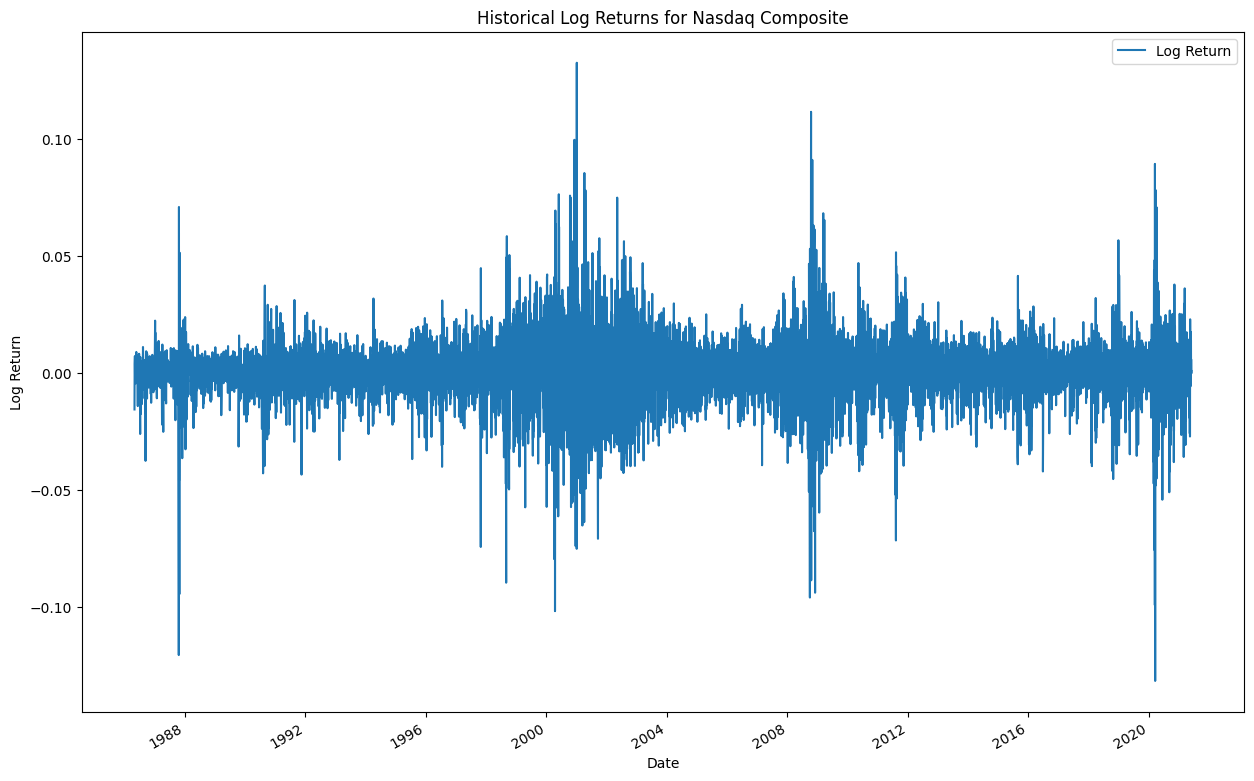

In [179]:
# Calculate log returns for Nasdaq Composite.
data_frames_per_index["IXIC"]["Log Return"] = np.log(
    data_frames_per_index["IXIC"]["Adj Close"]
    / data_frames_per_index["IXIC"]["Adj Close"].shift(1)
)

# Generate time series graph of log returns for Nasdaq Composite.
data_frames_per_index["IXIC"].plot(
    x="Date",
    y=[
        "Log Return",
    ],
    xlabel="Date",
    ylabel="Log Return",
    title=f"Historical Log Returns for Nasdaq Composite",
    figsize=(15, 10),
)
